# Модель предсказания температуры стали

Задача бизнеса - снизить энергопотребление на этапе обработки стали. Сделать это предполагается засчет разработки модели, предсказывающей температуру стали в зависимости от значений других технологических характеристик процесса. Как мы можем это сделать?

### Цель проекта:

> Разработать модель, предсказывающую температуру стального расплава, в зависимости от значений других технологических характеристик процесса.

В настоящий момент цель проекта звучит недостаточно точно - совместно со старшими коллегами, а также представителями бизнеса нам нужно уточнить возможность (с учетом имеющихся данных) и целесообразность (а нужно ли вообще разрабатывать модель машинного обучения для решения данной задачи? Может быть можно решить задачу иначе?)

Для разрешения этих моментов посмотрим на предоставленные нам данные, проведем их исследовательский анализ и сформулируем перечень уточняющих вопросов. 

Но перед этим разберемся с последовательностью этапов технологического процесса.

### Понимание технологического процесса

1) Расплавленная сталь заливается в ковш (она имеет температуру T0. Здесь и далее в скобках обозначены целевые признаки - для лучшей ориентации по проекту в дальнейшем). Сталь разогревается графитовыми электродами до нужной температуры (T1).

2) Этап десульфурации стали. Здесь нам необходимо перегнать серу из состояния FeS (связка с железом) в "шлаковое" состояние CaS - связка с кальцием и, тем самым, уменьшить её содержание в расплавленной стали до целевого уровня (T2). Делается это посредством введения в состав расплава извести (в среднем по сторонним источникам). 
> Можно предположить, что на этом этапе также будет наблюдаться СНИЖЕНИЕ температуры расплава - в первую очередь, за счет "естественного" теплообмена с окружающей средой, а также потерь на разогрев вводимых известковых добавок. Следовательно, на выходе должна быть температура этапа T2. Однако, если электроды нагревают смесь на всём времени данного этапа, вполне возможно, что T2 = T1. Узнаем это при исследовании данных и уточним данный момент.

3) Легирование стали. Этот этап сам по себе содержит мини-цикл, которые повторяется вплоть до достижения целевых значений температуры (T3_final) и химического состава (Fe_final). Он включает следующие этапы:

- разогрев расплава (T3_i -> T3_i+1, T3_0 = T2)
- введение легирующих добавок (Fe3_i -> Fe3_i+1)
- продувка инертным газом (???)

> Полагаю, на этом этапе есть несколько моментов, которые нужно уточнить: \
- наверняка, есть какие-то ограничения, которые не позволяют выполнить весь этап №3 в 1 итерацию - что это за ограничения? По объему вводимой добавке, по температуре и т.д.?
- на этом этапе, вероятно, расходуется больше всего энергии - за счет многократного (нам пока неизвестно СКОЛЬКИкратного) нагрева расплава.

4) Финальный этап. В соответствии с условием, здесь возможно 2 направления - на доводку и на разлив по слябам (по сути - формование конечного продукта металлургического производства). Как я понял, доводка - это часть процесса легирования, т.к. предполагает доведение до целевого значения по химическому составу и температуре. Стало быть, этап №4 - этап разливки.

На основании собранной нами логики, мы можем предположить, что основной интерес представляют этапы №1-3 - на которых осуществляются разнонаправленные движения температуры - нагрев на этапах №1 и 3 и охлаждение (это не точно) - на этапе №2.

Обратимся к имеющимся у нас в наличии файлам с данными. Но перед этим импортируем библиотеки.

### Импортируем библиотеки

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns 

from datetime import datetime, timedelta
from IPython.display import display

import warnings
import re
import time

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_absolute_error

import lightgbm as lgb

In [3]:
warnings.filterwarnings("ignore")

# 1. Исследовательский анализ данных

В наличии 7 файлов с данными. Разделим их по этапам процесса.

### Этап №1
- `data_arc.csv` — данные об электродах; 

### Этап №3
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` — данные о подаче сыпучих материалов (время);
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).
- `data_temp.csv` — результаты измерения температуры;
- `data_gas.csv` — данные о продувке сплава газом;

Для этапов №2 и 4 данных "не завезли". Вполне соответствует предположенной нами логике!

Наиболее очевидным (и от того интересным) является файл с результатами измерения температуры. Вероятно именно он нам и нужен. Также, вполне возможно, что он "сквозной" - в нем содержатся данные об изменении температуры по всем этапам. 

Узнаем это! \
Посмотрим на данные! \
(звучит как здоровский лозунг)

# Этап №1

In [4]:
electrode_data = pd.read_csv('/datasets/final_steel/data_arc.csv')
electrode_data

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768


In [5]:
electrode_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Типы данных для столбцов 'key' и мощности - адекватны содержащимся там данным. Для столбцов "начала" и "конца" - нет. В дальнейшем нам потребуется перевести их в соответствующий дататаймовый формат.

В столбце 'key' - номер партии. По спискам таких партий - 3241. Проверим, сколько из них "добралось" до нашей таблицы.

In [6]:
len(electrode_data['key'].unique())

3214

3241 - 3214 = 27 "холостых" пусков - не получивших своего места в истории. Будем иметь в виду. Посмотрим на распределение циклов по количеству итераций.

In [7]:
grouped_electrode = electrode_data.groupby(by = 'key').count()
grouped_electrode['Начало нагрева дугой'].describe()

count    3214.000000
mean        4.628500
std         1.608647
min         1.000000
25%         4.000000
50%         4.000000
75%         6.000000
max        16.000000
Name: Начало нагрева дугой, dtype: float64

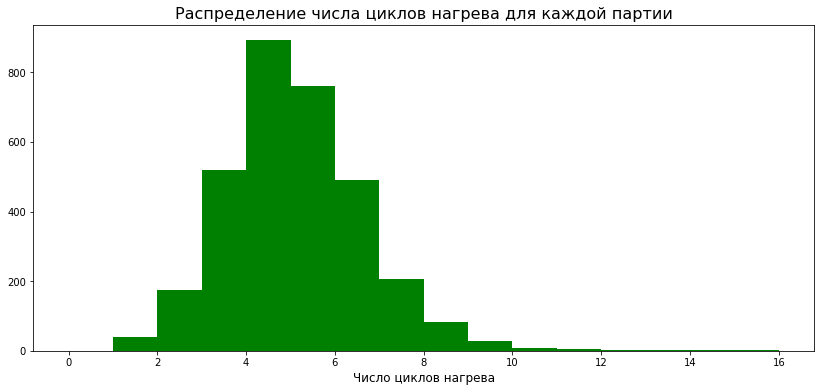

In [8]:
plt.figure(figsize = (14,6))
plt.title('Распределение числа циклов нагрева для каждой партии', fontsize = 16)
plt.xlabel('Число циклов нагрева', fontsize = 12)
plt.hist(grouped_electrode['Начало нагрева дугой'], bins = 16, range = (0,16), color = 'green')
plt.show()

Перед нами обычное нормальное распределение со средним значением около 4.5 итераций. Максимальное число циклов - в пределах одной партии = 1. Максимальное = 16. Однако всё, что выше 10 - скорее всего "выброс" и участвовать в наших исследованиях не должно. Стоит ли выбрасывать - вопрос к тимлиду и представителям бизнеса. Зафиксируем этот вопрос и зададим его, если в этом будет смысл. Далее, посмотрим на суммарную длительность наших циклов. Длительность будет определяться 2 показателями - длительностью между абсолютным началом и концом партии, а также суммарной длительностью НАГРЕВА (т.е. суммарным временем всех итераций).

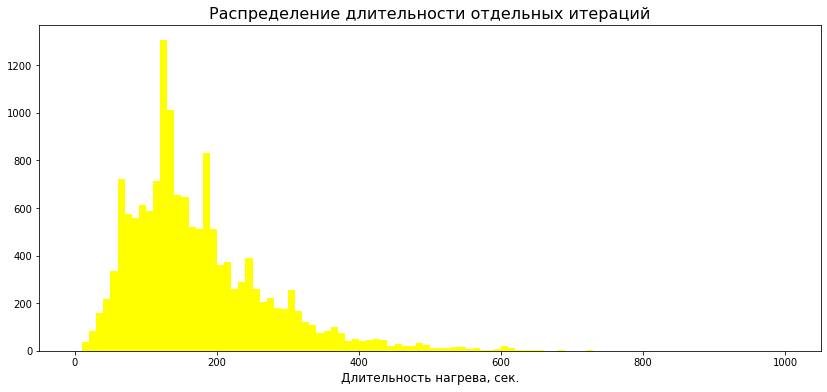

In [9]:
def str_to_time(string):
    return datetime.strptime(string, '%Y-%m-%d %H:%M:%S')

def delta_to_sec(timedelta):
    return timedelta.seconds

electrode_data['single_iteration_time'] = electrode_data['Конец нагрева дугой'].apply(str_to_time) - \
                                        electrode_data['Начало нагрева дугой'].apply(str_to_time)

electrode_data['Продолжительность нагрева в секундах'] = electrode_data['single_iteration_time'].apply(delta_to_sec)

plt.figure(figsize = (14,6))
plt.title('Распределение длительности отдельных итераций', fontsize = 16)
plt.xlabel('Длительность нагрева, сек.', fontsize = 12)
plt.hist(electrode_data['Продолжительность нагрева в секундах'], bins = 100, range = (0,1000), color = 'yellow')
plt.show()

In [10]:
(electrode_data['single_iteration_time'].apply(delta_to_sec) / 60).describe()

count    14876.000000
mean         2.861182
std          1.636447
min          0.183333
25%          1.783333
50%          2.450000
75%          3.566667
max         15.116667
Name: single_iteration_time, dtype: float64

Нормальное распределение значений с длинным (и, скорее всего, отбрасываемым) хвостом справа. Вне вершины есть также несколько пиков - вероятно, они указывают на совмещение в рамках имеющегося набора данных нескольких нормальных распределений, соответствующих неким УНИФИЦИРОВАННЫМ циклам (которые, например, соответствуют возможным режимам функционирования используемых металургических линий и т.п.). Интересное предположение, попробуем проверить его с помощью корреляционной матрицы по 3 признакам - мощности (2 столбца) и длительности итерации в секундах.

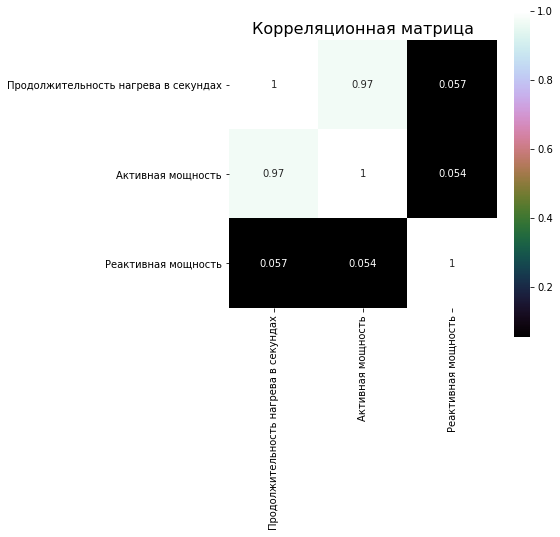

In [11]:
correlation_matrix = electrode_data[['Продолжительность нагрева в секундах', 'Активная мощность', 'Реактивная мощность']].corr()

plt.figure(figsize = (6,6))
sns.heatmap(correlation_matrix, annot = True, square=True, cmap='cubehelix')

plt.title('Корреляционная матрица', fontsize = 16)
plt.show()

Неожиданно. Но не очень. Корреляция между длительностью этапов и активной мощностью практически равна 1. О чем это говорит? О прямой зависимости между данными признаками. Построим точечную диаграмму и подумаем, что ещё можно из этого понять.

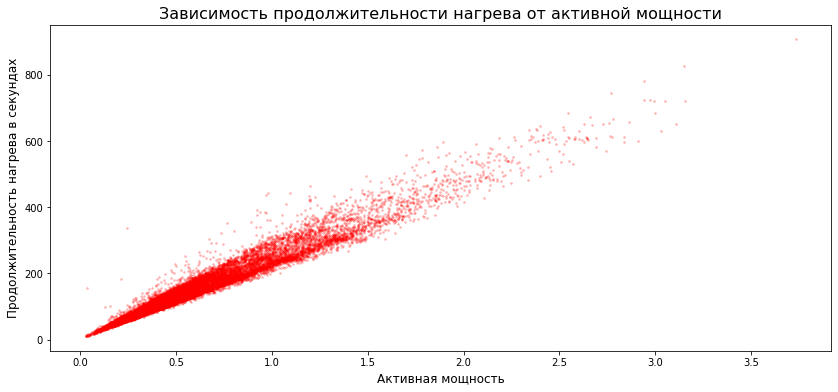

In [12]:
plt.figure(figsize = (14,6))
plt.scatter(electrode_data['Активная мощность'], 
            electrode_data['Продолжительность нагрева в секундах'], 
            s = 3, color = 'red', alpha = 0.2)
plt.xlabel('Активная мощность', fontsize = 12)
plt.ylabel('Продолжительность нагрева в секундах', fontsize = 12)
plt.title('Зависимость продолжительности нагрева от активной мощности', fontsize = 16)
plt.show()

Да, всё как по учебнику. Корреляция между признаками - линейная. Да, есть небольшое отклонение от совершенно прямой линии, но, в как и любая случайная величина, распределение вокруг среднего значения - вполне себе нормальное явление. 

Вероятно, процесс, описываемый представленными данными, носит "затухающий характер" - подали мощность на электроды, они разогрелись, мощность "выключили" начался теплообмен между "раскрасневшимся" (ведь графит тоже краснеет?) электродом и стальным расплавом, температура расплава растет, электрода падает - и так до стабилизации температуры системы "электрод - расплав" на едином уровне. Отсюда и расхождение в длительности - внешние факторы могут отличаться и вносить свой вклад в конечный результат.

А теперь, внимание - главный вопрос. Что с этим можно сделать и зачем нам вообще это знать?

1) Если мы знаем о существовании прямой зависимости между признаками, то использование обоих при обучении модели бессмысленно - нам необходимы только НЕЗАВИСИМЫЕ (по-крайней мере НЕЗАВИСИМЫЕ ПРЯМО) признаки. А это - повышение скорости обучения (меньше признаков) и снижение необходимых (для обучения и работы модели) ресурсов.
2) Знаем входную мощность на электроде - знаем "ориентировочное" время, когда цикл будет завершен. Стоит ли фиксировать после этого ещё один признак? Большой вопрос, при условии, если он более нигде не используется (а вот этого мы не знаем - уточнить!).

Соберем суммарное значение длительности для каждой партии. Напомню - 2 столбца. В первом "чистая длительность нагрева", во втором - от начала до конца каждой партии.

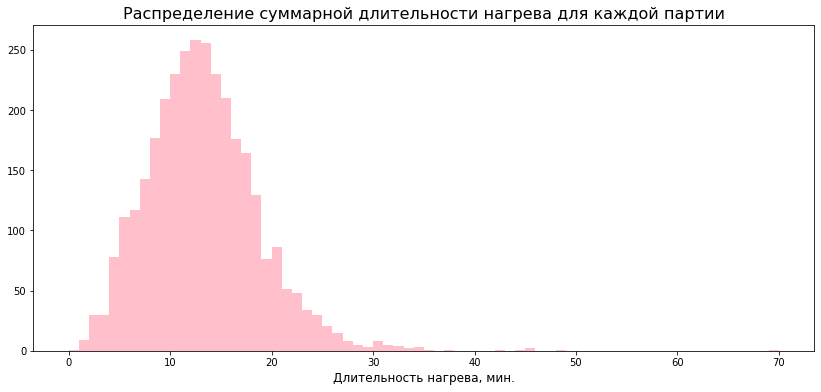

In [13]:
plt.figure(figsize = (14,6))
plt.title('Распределение суммарной длительности нагрева для каждой партии', fontsize = 16)
plt.xlabel('Длительность нагрева, мин.', fontsize = 12)
plt.hist(electrode_data.groupby(by = 'key').sum()['Продолжительность нагрева в секундах'] / 60, 
         bins = 70, range = (0, 70), color = 'pink')
plt.show()

In [14]:
(electrode_data.groupby(by = 'key').sum()['Продолжительность нагрева в секундах'] / 60).describe()

count    3214.000000
mean       13.242984
std         5.540810
min         0.950000
25%         9.516667
50%        12.833333
75%        16.383333
max        69.816667
Name: Продолжительность нагрева в секундах, dtype: float64

В среднем в пределах одной партии "чистый" нагрев происходит в течение 13 минут. \
И вновь перед нами - нормальное распределение. Это хорошо. А "хвост", скорее всего, устранится вместе с очисткой от аналогичных выбросов "первичных" признаков.

Теперь построим аналогичный график для СУММАРНОЙ ДЛИТЕЛЬНОСТИ (с учетом временных гэп-ов между отдельными итерациями).

In [15]:
time_plus_gap = (electrode_data.groupby(by = 'key').max()['Конец нагрева дугой'].apply(str_to_time) - 
                 electrode_data.groupby(by = 'key').min()['Начало нагрева дугой'].apply(str_to_time))
time_plus_gap

key
1      00:26:23
2      00:19:04
3      00:25:25
4      00:18:13
5      00:22:42
         ...   
3237   00:22:30
3238   00:15:10
3239   00:48:50
3240   00:58:44
3241   00:37:10
Length: 3214, dtype: timedelta64[ns]

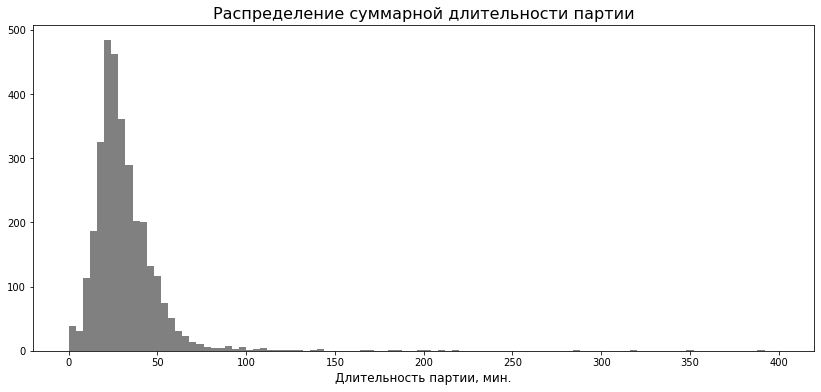

In [16]:
plt.figure(figsize = (14,6))
plt.title('Распределение суммарной длительности партии', fontsize = 16)
plt.xlabel('Длительность партии, мин.', fontsize = 12)
plt.hist(time_plus_gap.apply(delta_to_sec) / 60, 
         bins = 100, range = (0, 400), color = 'grey')
plt.show()

In [17]:
(time_plus_gap.apply(delta_to_sec) / 60).describe()

count    3214.000000
mean       31.642294
std        21.085088
min         0.950000
25%        21.004167
50%        27.683333
75%        38.095833
max       391.416667
dtype: float64

Всё та же "шляпа" - но вид сбоку. Суть графика остается прежней. Нормальность - на месте, хвост (или даже "ХВОСТИЩЕ") - тоже на месте. В дополнение к проведенному анализу посмотрим на вклад временных ГЭПОВ в итоговое значение длительности. Потому что переход от 13 к 31 минуте (в среднем) - это сильно. Вероятно, мы сможем обнаружить точки роста для бизнеса за счет сокращения суммарной длительности каждой партии - путем перехода к "наилучшим" с точки зрения времени и используемой мощности значениям. 

Хотя, конечно, на любые перекрои процессов - всегда воля руководителя и технолога. Ведь я не понимаю до конца (и потому не понимаю совсем) сути происходящих процессов. А значит и не могу давать какие-то советы. Только вместе с представителем, только вместе с тимлидом. 

Построим точечный график распределения значений ВРЕМЕННОГО ГЭПА в зависимости от СУММАРНОЙ длительности.

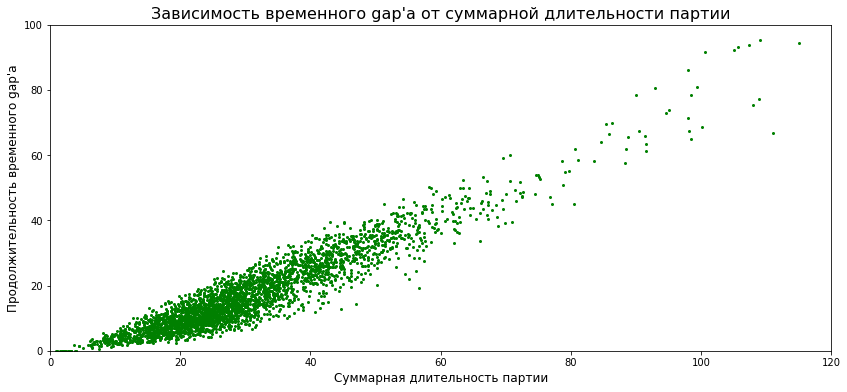

In [18]:
plt.figure(figsize = (14,6))
plt.scatter((time_plus_gap.apply(delta_to_sec) / 60), 
            (time_plus_gap.apply(delta_to_sec) / 60) - (electrode_data.groupby(by = 'key')
                                                        .sum()['Продолжительность нагрева в секундах'] / 60),
            s = 4, color = 'green')
plt.xlim(0,120)
plt.ylim(0,100)
plt.xlabel('Суммарная длительность партии', fontsize = 12)
plt.ylabel("Продолжительность временного gap'а", fontsize = 12)
plt.title("Зависимость временного gap'а от суммарной длительности партии", fontsize = 16)
plt.show()

И это мы сегодня уже видели. Чем больше длительность, тем больше временной гэп. Отсюда вопрос - а стоит ли повышать длительность (читай используемую АКТИВНУЮ МОЩНОСТЬ) процесса? Вопрос к размышлению.

С данными по первому этапу разобрались. На очереди - проволочные и сыпучие материалы.

# Этап №3

Здесь у нас целых 4 файла. Откроем их все вместе и подумаем, есть ли возможность (техническая, логическая) их скомпоновать для совместного анализа.

In [19]:
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk_raw = data_bulk.copy()
data_bulk.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


In [20]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [21]:
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_bulk_time.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaN,NaN,NaN,2019-05-03 15:04:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:55:46,NaN,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaN,NaN,NaN,2019-05-03 15:47:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:41:00,NaN,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:18:52,NaN,2019-05-03 16:18:52,2019-05-03 16:18:52


In [22]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [23]:
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
data_wire_raw = data_wire.copy()

In [25]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [26]:
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
data_wire_time.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:03:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [28]:
print(len(data_bulk['key'].unique()), len(data_bulk_time['key'].unique()))

3129 3129


In [29]:
print(len(data_wire['key'].unique()), len(data_wire_time['key'].unique()))

3081 3081


Что можно сказать после "первичного" осмотра нашего "пациента"?

1) Данных "не хватает" - в том смысле, что заполнены совершенно не все столбцы. Значит далеко не все емкости с сыпучим материалов и "подаватели проволоки" могут быть использованы и используются в рамках одного цикла. Плюс, нам неизвестно - один и тот же материал подается из всех контейнеров или нет. Если да - то можно их "объединить" в один признак. Если нет - то нужно продолжать пилить "по отдельности";
> Да, вот это надо уточнить!

2) Не все "партии" одинаково полезны. Данные по 1 этапу представлены для 3214 партий, данные для "сыпучего" - для 3129 партий, а данные для "проволочного" - для 3081 партии. Значит ли это, что в смесь ничего не добавлялось и сразу всё шло в сторону легирования? Вполне может быть. Косвенно мы можем это проверить по наличию среди объектов строчек с пропусками ВЕЗДЕ, кроме столбца "номер партии". Проверим. И спросим, если нужно. 
> Это тоже спросить!

Начнем с "сыпучей" части.

По "количеству" значений столбцы соответствующие различным "контейнерам" совпадают для файлов с массой и временем (есть поступление, есть время поступления). Для успокоения проверим и этот момент.

In [30]:
pd.concat([data_bulk['Bulk 1'], data_bulk_time['Bulk 1']], axis = 1).dropna()

,Bulk 1,Bulk 1
11,46.0,2019-05-03 17:50:19
48,27.0,2019-05-05 10:09:13
49,48.0,2019-05-05 11:01:42
50,29.0,2019-05-05 11:59:23
51,46.0,2019-05-05 13:13:45
...,...,...
3078,28.0,2019-08-30 10:54:00
3083,16.0,2019-08-30 15:39:35
3084,26.0,2019-08-30 16:20:30
3088,28.0,2019-08-30 19:23:57


Да, 252 значения, как и было изначально. "Половинок" не завезли.

Теперь ищем строки, полные пропусков. Для упрощения задачи заменим пропуски на нули. Сути дела это не поменяет.

In [31]:
data_bulk = data_bulk.fillna(0)

def gaps_count(row):
    gaps = 0
    for element in row:
        if element == 0:
            gaps += 1
    return len(row) - gaps - 1

bulk_number = data_bulk.copy()

bulk_number['gaps_number'] = data_bulk.apply(gaps_count, axis = 1)
bulk_number

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,gaps_number
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,4
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,4
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,4
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,4
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0,4
3125,3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0,4
3126,3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0,4
3127,3240,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0,3


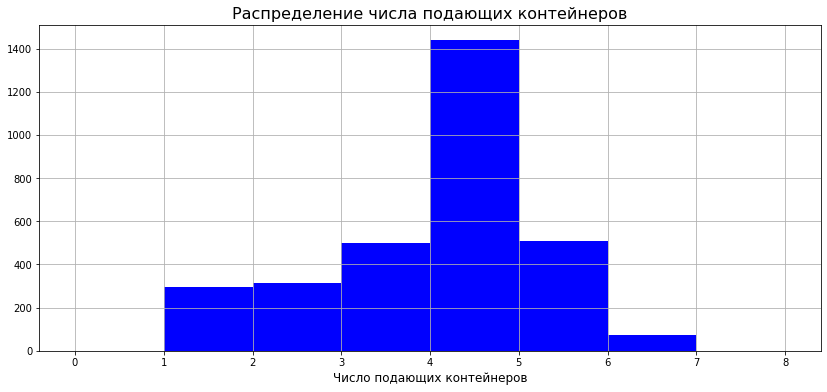

In [32]:
plt.figure(figsize = (14,6))
plt.title('Распределение числа подающих контейнеров', fontsize = 16)
plt.xlabel('Число подающих контейнеров', fontsize = 12)
bulk_number['gaps_number'].hist(bins = 8, range = (0, 8), color = 'blue')
plt.show()

"Пустых" строк нет. Вероятней всего, отсутствующие партии - это партии материала, которые НЕ НУЖНО десульфурировать. По крайней мере, с использованием "сыпучки". Посмотрим на "проволочную" версию.

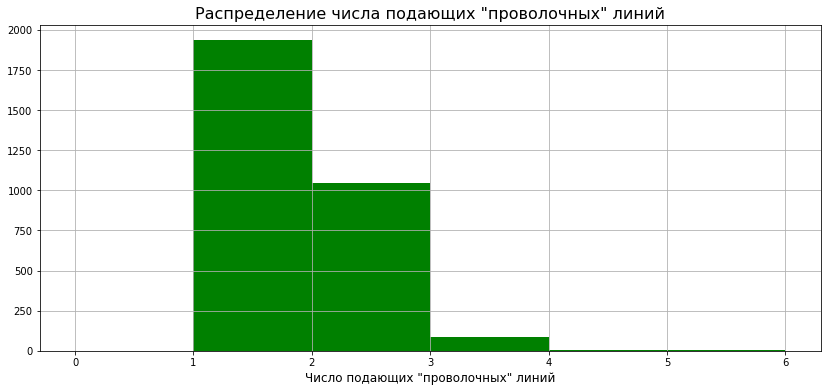

In [33]:
data_wire = data_wire.fillna(0)
wire_number = data_wire.copy()

wire_number['gaps_number'] = data_wire.apply(gaps_count, axis = 1)

plt.figure(figsize = (14,6))
plt.title('Распределение числа подающих "проволочных" линий', fontsize = 16)
plt.xlabel('Число подающих "проволочных" линий', fontsize = 12)
wire_number['gaps_number'].hist(bins = 6, range = (0, 6), color = 'green')
plt.show()

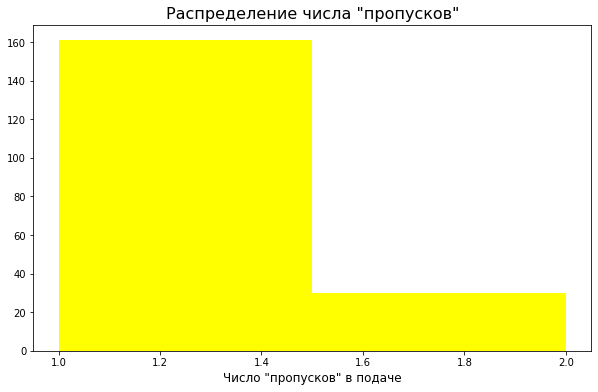

In [34]:
key_electrode = pd.DataFrame(data = [], columns = ['electrode'], index = electrode_data['key'].unique()).fillna(0)
key_bulk = pd.DataFrame(data = [], columns = ['bulk'], index = data_bulk['key']).fillna(0)
key_wire = pd.DataFrame(data = [], columns = ['wire'], index = data_wire['key']).fillna(0)

final_key = pd.concat([key_electrode, key_bulk, key_wire], axis = 1, join = 'outer')
final_key = final_key.fillna(1)

def row_sum(row):
    return row.sum()

final_key['sum'] = final_key.apply(row_sum, axis = 1)


plt.figure(figsize = (10,6))
plt.title('Распределение числа "пропусков"', fontsize = 16)
plt.xlabel('Число "пропусков" в подаче', fontsize = 12)
plt.hist(final_key['sum'], bins = 2, range = (1,2), color = 'yellow')
plt.show()

Примерно 160 партий, в которых подается ЛИБО "сыпучка", ЛИБО проволока. И около 30 партий, где стадия ЛЕГИРОВАНИЯ отсутствует. Возможно ли такое? Да, возможно. Нужны ли нам такие данные для обучения модели? Да, нужны, если эти партии присутствуют в дальнейшем - например, на этапе легирования - т.е. доходят ли они до конца - или это "ошибочные" (холостые) партии.

Поскольку мы пока не знаем, РАЗЛИЧНЫЕ ли присадки для ЛЕГИРОВАНИЯ в каждом из подающих источников, предположим их ИДЕНТИЧНОСТЬ (из всех мест - одно и то же) и посмотрим, есть ли какая-то логика в распределении значений СУММАРНОЙ массы (или не массы?) попадающего в расплав ЛЕГИРУЮЩЕГО материала. 

Отдельно - для сыпучки, отдельно - для проволоки.

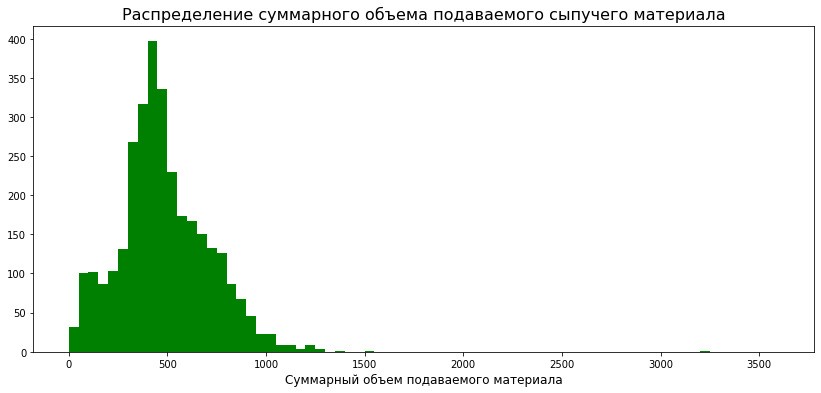

In [35]:
def row_bulk_wire_sum(row):
    return row[1:-1].sum()

data_bulk['sum'] = data_bulk.apply(row_bulk_wire_sum, axis = 1)

plt.figure(figsize = (14,6))
plt.title('Распределение суммарного объема подаваемого сыпучего материала', fontsize = 16)
plt.xlabel('Суммарный объем подаваемого материала', fontsize = 12)
plt.hist(data_bulk['sum'], bins = 72, range = (0, 3600), color = 'green')
plt.show()

В принципе, ничего особо криминального. Мы снова близки к нормали. И даже можно предположить, что наша гипотеза действительно верна - в "корзинках" идентичный материал. Причин для 15 корзин может быть предостаточно. Поэтому - ничего удивительного. Тем не менее, Этот момент лучше уточнить.
> Уточнить!

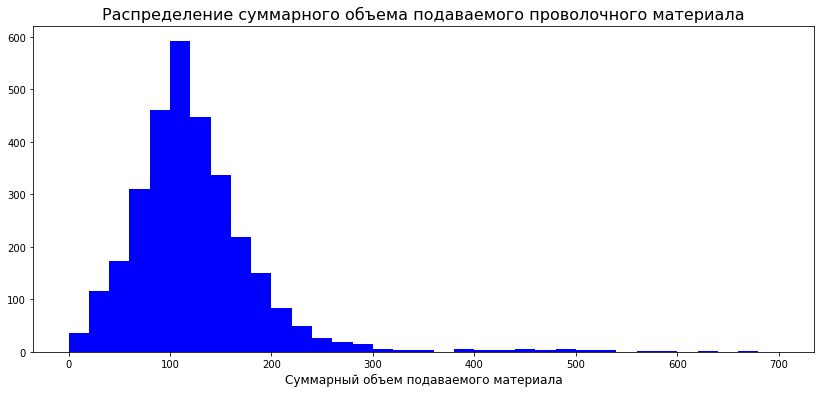

In [36]:
data_wire['sum'] = data_wire.apply(row_bulk_wire_sum, axis = 1)

plt.figure(figsize = (14,6))
plt.title('Распределение суммарного объема подаваемого проволочного материала', fontsize = 16)
plt.xlabel('Суммарный объем подаваемого материала', fontsize = 12)
plt.hist(data_wire['sum'], bins = 35, range = (0, 700), color = 'blue')
plt.show()

А вот здесь всё ещё более нормально. Проверим ещё один вариант - СОВМЕСТНУЮ массу "сыпучего" и "Проволочного".

Учитывая, что "сыпучий" вариант куда более массивен - в 5 раз большее среднее значений и т.д., для понимания изменений, нанесем на гистограмму также значения для "сыпучего" материала.

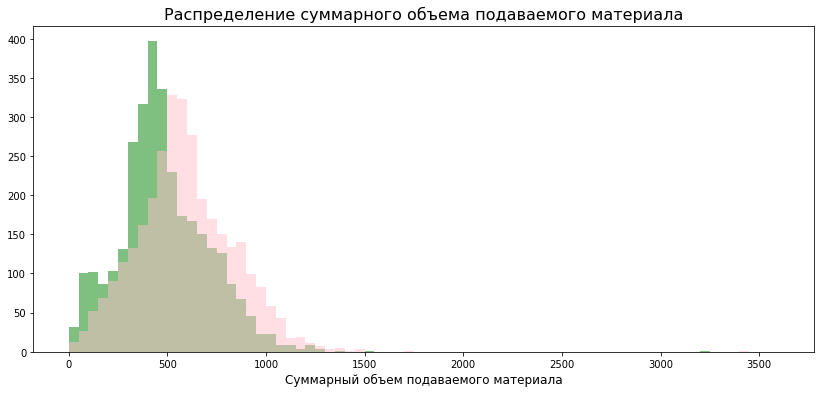

In [37]:
bulk_wire_sum = data_bulk[['key', 'sum']].merge(data_wire[['key', 'sum']], how = 'outer', on = ['key'], copy = True).fillna(0)
bulk_wire_sum['sum'] = bulk_wire_sum['sum_x'] + bulk_wire_sum['sum_y']

plt.figure(figsize = (14,6))
plt.title('Распределение суммарного объема подаваемого материала', fontsize = 16)
plt.xlabel('Суммарный объем подаваемого материала', fontsize = 12)
plt.hist(data_bulk['sum'], bins = 72, range = (0, 3600), color = 'green', alpha = 0.5)
plt.hist(bulk_wire_sum['sum'], bins = 72, range = (0, 3600), color = 'pink', alpha = 0.5)
plt.show()

Логика вновь на месте - распределение сместилось вправо в сторону большей нормальности + повысилось среднее значение "Потребляемой" добавки. 

Следующий файл!

In [38]:
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_temp

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


Откровение - мы используем одни и те же электроды для разогрева смеси на всех этапах!

Сразу же видим пропуски в разделе температура - посмотрим, сколько их. Ведь если наша задача - предсказать температуру, а у нас нет значений целевого признака, такие партии будут отправлены "под нож". Целиком. 

Здесь нам поможет второй столбец - с временем замера. Если времён замера 5, а замерянных температур - всего 2 - эта партия "отлетает". Приступим.

In [39]:
temp_gaps = data_temp.groupby(by = 'key').count()
temp_gaps['delta'] = temp_gaps['Время замера'] - temp_gaps['Температура']

temp_gaps[temp_gaps['delta'] > 0]

,Время замера,Температура,delta
key,,,
2500,4,1,3
2501,5,1,4
2502,7,1,6
2503,4,1,3
2504,3,1,2
...,...,...,...
3237,5,1,4
3238,3,1,2
3239,8,1,7


Прискорбно наблюдать такие ситуации. Было 3+ тысяч значений, после проверки на "наличие" целевого признака осталось ровно 2500.

С другой стороны, это может быть указанием на НЕИЗМЕННОСТЬ температуры в процессе (хоть это и маловероятно) - а значит данные выбрасывать не нужно. С другой стороны, большой вопрос - а нужны ли нам такие данные (если мы всё-таки предсказываем температуру), в которых температура НЕ МЕНЯЕТСЯ? Нужно подумать и спросить.

Также нужно проверить "причины" возникновения подобной ситуации, связанные с человеческим и техническими факторами. 
> Уточнить!

Посмотрим на статистическую составляющую показателя температуры.

In [40]:
data_temp['Температура'].describe()

count    13006.000000
mean      1591.840920
std         21.375851
min       1191.000000
25%       1581.000000
50%       1591.000000
75%       1601.000000
max       1705.000000
Name: Температура, dtype: float64

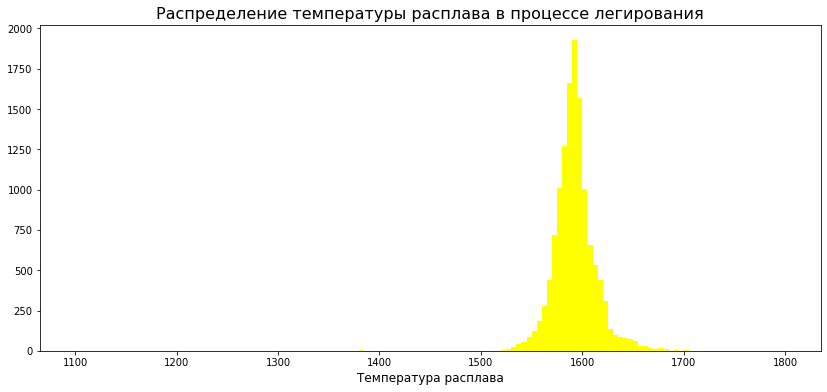

In [41]:
plt.figure(figsize = (14,6))
plt.title('Распределение температуры расплава в процессе легирования', fontsize = 16)
plt.xlabel('Температура расплава', fontsize = 12)
plt.hist(data_temp['Температура'], bins = 140, range = (1100, 1800), color = 'yellow')
plt.show()

Несколько выбросовых значений слева и, возможно, справа. \
Распределение температуры НОРМАЛЬНО. Подходит для "участия" в качестве целевого признака. Другой вопрос - зачем на это нужно? Продолжаем усиленно думать.

Прикинем, насколько в ходе партии может меняться температура расплава - для понимания возможного целевого признака - может нам стоит предсказывать не температуру, а ИЗМЕНЕНИЕ температуры в зависимости от активной мощности, количества добавок и т.д.

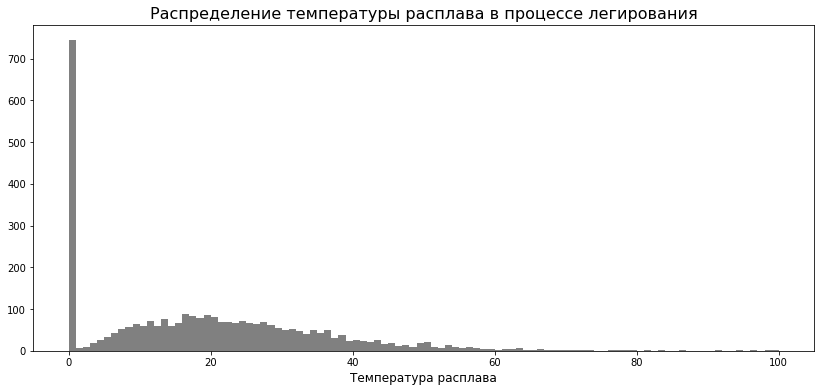

In [42]:
temp_analysis = pd.DataFrame(data = [], columns = ['max_temp', 'min_temp'])
temp_analysis['max_temp'] = data_temp.groupby('key').max()['Температура']
temp_analysis['min_temp'] = data_temp.groupby('key').min()['Температура']

temp_analysis['delta'] = temp_analysis['max_temp'] - temp_analysis['min_temp'] 

plt.figure(figsize = (14,6))
plt.title('Распределение температуры расплава в процессе легирования', fontsize = 16)
plt.xlabel('Температура расплава', fontsize = 12)
plt.hist(temp_analysis['delta'], bins = 100, range = (0, 100), color = 'grey')
plt.show()

In [43]:
temp_analysis['delta'].describe()

count    3216.000000
mean       19.408893
std        21.567207
min         0.000000
25%         5.000000
50%        17.000000
75%        29.000000
max       409.000000
Name: delta, dtype: float64

400 градусов - очевидный выброс. Как впрочем и изменения температуры свыше 60 градусов. Вероятно именно на них и ориентирован наш проект. Ведь разогреть НЕЧТО температурой 1600+ градусов даже на 1 градус требует огромных энергетических затрат. Следовательно, нам стоит предотвратить (в будущем) возникновение подобных ситуаций.

700 нулей - "псевдовыбросы" - нужно уточнять их происхождение (фиксировали этот вопрос ранее).

Есть ещё 1 момент, который стоит проверить. Но к нему я обращусь только в случае "крайней необходимости" - это вопрос "нанесения" на одну временную ось ВСЕХ событий происходящих в исследуемом процессе и понимания, что за чем следует.

Посмотрим на данные по продувке.

In [44]:
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_gas

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


Судя по всему, представленные значения - ПОСТОЯННЫ в пределах одной партии. Какой именно признак ГАЗА перед нами - объем, давление или что-то ещё - неизвестно, хотя было бы неплохо узнать.
>уточнить.

Смотрим на распределение.

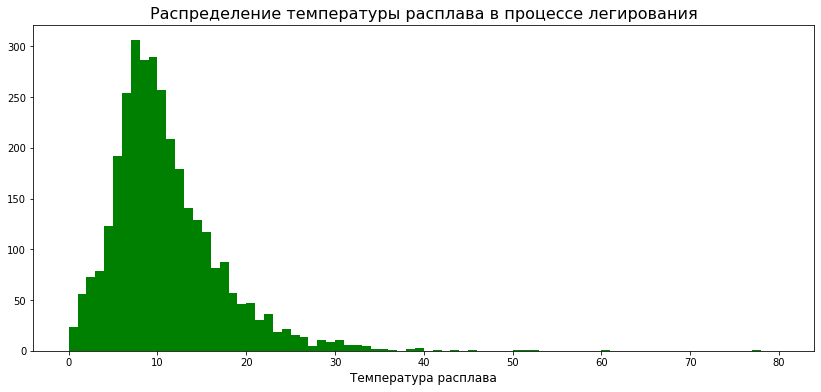

In [45]:
plt.figure(figsize = (14,6))
plt.title('Распределение температуры расплава в процессе легирования', fontsize = 16)
plt.xlabel('Температура расплава', fontsize = 12)
plt.hist(data_gas['Газ 1'], bins = 80, range = (0, 80), color = 'green')
plt.show()

Длинный хвост всё так же на месте, в остальном - нормальность распределения на лицо. 

Поскольку особых "новых данных" мы в ходе просмотра последней таблицы не обнаружили, воспользуемся секретным оружием. 
Выстроим ВРЕМЕННОЙ ряд, описывающий ПОСЛЕДОВАТЕЛЬНОСТЬ происходящих событий.
Сделаем это для нескольких партий, а затем подумаем, каких данных нам не хватает и что стоило бы добавить.

Начнем с партии №1.

Логика такая - обозначим каждую временную точку своим "шильдиком". \
Шильдиков у нас 5:
- Начало нагрева = 1
- Конец нагрева = 2
- Внесение "сыпучки" = 3
- внесение "проволоки" = 4
- Фиксация температуры = 5

In [46]:
def stage_column_creator(data, column, batch_number, stage_number):
    time_data = pd.DataFrame(np.array(data[data['key'] == batch_number][column]),
                             columns = ['datetime'])
    index_data = pd.DataFrame(np.zeros(len(time_data)) + stage_number, columns = ['stage']).astype('int')
    
    return pd.concat([time_data, index_data], axis = 1)

def stage_row_creator(data, batch_number, stage_number):
    time_data = pd.DataFrame(np.array(data[data['key'] == batch_number]
                                      .drop(['key'], axis = 1))
                             .T, columns = ['datetime']).dropna().reset_index(drop = True)
    
    index_data = pd.DataFrame(np.zeros(len(time_data)) + stage_number, columns = ['stage']).astype('int')
    
    return pd.concat([time_data, index_data], axis = 1)


def timeline_collector(batch_number):
    
    stage1 = stage_column_creator(electrode_data, 'Начало нагрева дугой', batch_number, 1)
    stage2 = stage_column_creator(electrode_data, 'Конец нагрева дугой', batch_number, 2)
    stage3 = stage_row_creator(data_bulk_time, batch_number, 3)
    stage4 = stage_row_creator(data_wire_time, batch_number, 4)
    stage5 = stage_column_creator(data_temp, 'Время замера', batch_number, 5)
    
    final_table = pd.concat([stage1, stage2, stage3, stage4, stage5])
    
    final_table['datetime'] = final_table['datetime'].apply(str_to_time)
    
    return final_table.sort_values(by = 'datetime').reset_index(drop = True)

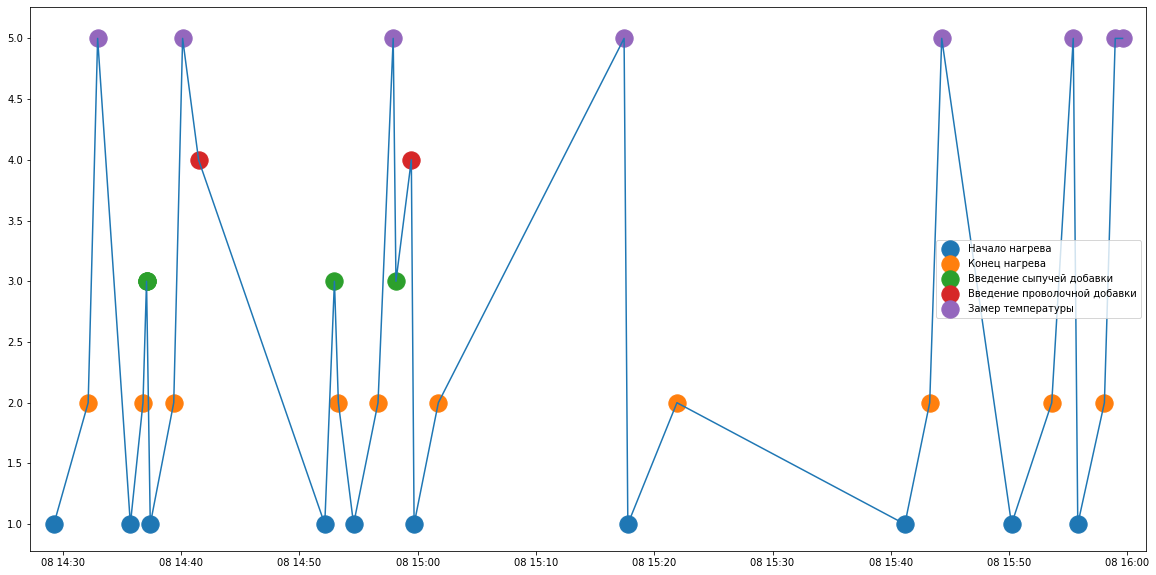

In [47]:
batch_1 = timeline_collector(1866)
batch_1.index = batch_1['datetime']

plt.figure(figsize = (20,10))
plt.xlim((batch_1['datetime'].min() - timedelta(minutes=2), batch_1['datetime'].max() + timedelta(minutes=2)))


plt.scatter(batch_1[batch_1['stage'] == 1].index, batch_1[batch_1['stage'] == 1]['stage'], s = 300)
plt.scatter(batch_1[batch_1['stage'] == 2].index, batch_1[batch_1['stage'] == 2]['stage'], s = 300)
plt.scatter(batch_1[batch_1['stage'] == 3].index, batch_1[batch_1['stage'] == 3]['stage'], s = 300)
plt.scatter(batch_1[batch_1['stage'] == 4].index, batch_1[batch_1['stage'] == 4]['stage'], s = 300)
plt.scatter(batch_1[batch_1['stage'] == 5].index, batch_1[batch_1['stage'] == 5]['stage'], s = 300)

plt.legend(['Начало нагрева', 'Конец нагрева', 'Введение сыпучей добавки', 'Введение проволочной добавки', 'Замер температуры'])

plt.plot(batch_1.index, batch_1['stage'])
plt.show()

Графики хороши, наглядны и вообще - лучше не придумать. единственная проблема - как бы нам что-то из них понять? 

Очень просто! Теперь мы можем получить ПОСЛЕДОВАТЕЛЬНОСТИ действий, которые осуществляются ПЕРЕД измерением температуры. Т.е. сейчас нам нужно наклепать СТРОКОВЫХ последовательностей и посчитать, ДО или ПОСЛЕ каких событий, как правило, осуществляется измерение температуры - так сказать, понять внутреннюю логику работы технологической линии. А также какие "входные данные" мы можем использовать для прогнозирования значения температуры.

Сперва соберем числовые последовательности для всех партий.

In [48]:
def events_liner(batch_list):
    
    event_lines = pd.DataFrame(data = [], columns = ['line'])
    
    for batch_number in batch_list:
#         print(batch_number)
        batch_data = timeline_collector(batch_number)
        event_lines.loc[batch_number, 'line'] = batch_data['stage'].astype('str').sum()
    
    
    return event_lines


unique_batch_list = (((pd.DataFrame(electrode_data['key'].unique())
                     .merge(pd.Series(data_bulk['key'].unique()).to_frame(), how = 'inner'))
                     .merge(pd.Series(data_wire['key'].unique()).to_frame(), how = 'inner'))
                     .merge(pd.Series(data_temp['key'].unique()).to_frame(), how = 'inner'))

In [49]:
%%time

line_data = events_liner(unique_batch_list[0])
line_data.head(10)

CPU times: user 1min 9s, sys: 69.8 ms, total: 1min 9s
Wall time: 1min 9s


,line
1,13332124125132512555
2,1255133324132512555
3,13332541251251253125
4,1333212413251255
5,1333241325124125
6,1251333243412512555
7,125513332413255125
8,13332413251212555
9,125133324513251245125
10,1251333244512125512551255


Готово. Какие комбинации нам нужно искать?
Думаю можно будет ограничиться 1 элементом ДО и 1 элементом ПОСЛЕ цифры 5. Сколько у нас может быть таких комбинаций?

5 - для элементов ДО, 5 для элементов ПОСЛЕ.

In [50]:
def end_stage(line):
    return line[-1]
line_data['end'] = line_data['line'].apply(end_stage)
line_data['end'].value_counts()

5    2866
2     154
3       3
4       1
Name: end, dtype: int64

In [51]:
line_data['end'].value_counts().max() * 100 / len(line_data['end'])

94.77513227513228

Ещё один важный инсайт - партия заканчивается измерением температуры в 94% случаев (как в больнице - 36.6? - выписываем). Вопрос в том, что делать с остальными партиями? Ведь для них НЕИЗВЕСТНЫ финальные значения температуры.

Напишем функцию, которая на вход будет принимать столбец с "линиями", а на выход давать количество "встреч" каждой из комбинаций (15, 25, 35, 45, 55) и (51, 52, 53, 54, 55). 55 и 55 - одно значений. На один пункт считать меньше. Причем число таких "измерений+измерений" нам, логически, смысла не прибавит. Поэтому ограничимся частотой "соседства" с другими "событиями".

In [52]:
def events_probability(events_line, pattern):
    return len(re.findall(pattern, events_line))

pattern_list_up = [str(i*10 + 5) for i in range(1, 5, 1)] 
pattern_list_down = [str(i) for i in range(51, 55, 1)] 

def pattern_counter(data_column, pattern_list):
    count_list = []
    for pattern in pattern_list:
        pattern_column = data_column.apply(events_probability, pattern = pattern)
        count_list.append(pattern_column.sum())
    
    return count_list

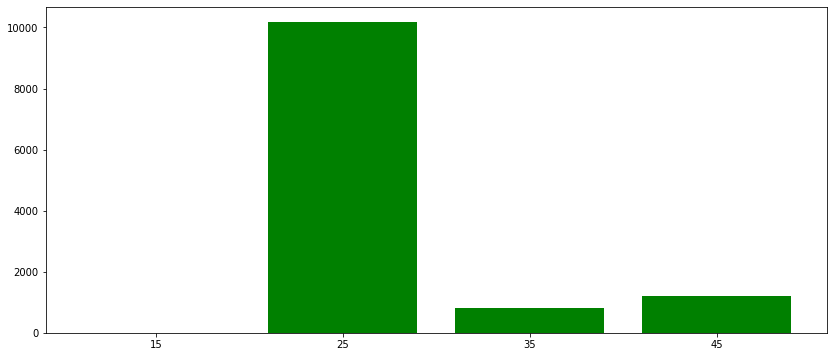

In [53]:
plt.figure(figsize = (14,6))
plt.bar(pattern_list_up, pattern_counter(line_data['line'], pattern_list_up), color = 'green')
plt.show()

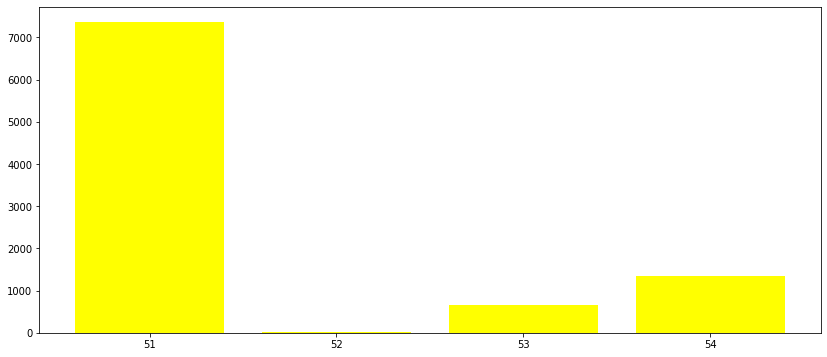

In [54]:
plt.figure(figsize = (14,6))
plt.bar(pattern_list_down, pattern_counter(line_data['line'], pattern_list_down), color = 'yellow')
plt.show()

Что мы можем СКАЗАТЬ, исходя из полученных результатов?

Измерение температуры, как правило происходит:
1) ПОСЛЕ ОКОНЧАНИЯ НАГРЕВА
2) ПЕРЕД НАЧАЛОМ НАГРЕВА

Также, с высокой долей вероятности эти точки пересекаются, превращаясь в вид "251" - КОНЕЦ НАГРЕВА + ЗАМЕР + НАЧАЛО НАГРЕВА. \
Это не сложно посчитать, но делать мы этого не будем.

# ПЛАН:

На основании проведенного исследования и (будущих) полученных ответов необходимо: 

1) ТИПИЗИРОВАТЬ внешний вид ОБЪЕКТА обучения - определиться с входными признаками, числом признаков, их видом (количественный, качественный) и т.д. Вероятнее всего это будут ВРЕМЕННЫЕ ОТРЕЗКИ МЕЖДУ измерениями температуры. Партии сами по себе крайне неоднородны и в первоначальном виде содержат различное число признаков. Потому брать партию как минимальную единицу для обучения модели смысла нет. 

2) Выбрать ВИД ЦЕЛЕВОГО признака - изменение температуры (между началом цикла и концом цикла), температура в конце цикла.

3) Предобработать данные - убрать выбросы (уже нашли), убрать аномалии, заполнить пропуски (в соответствии с ответами) и т.д. \ Нарезать данные на ОБЪЕКТЫ (в соответствии с п.1 ПЛАНа)

4) Выбрать модель, нарезать выборку на обучающую, валидационную и тестовую, выбрать метод обучения модели, метрику и т.д. Сравнить варианты, выбрать наиболее оптимальные с точки зрения НЕОБХОДИМОГО критерия оценки УСПЕШНОСТИ.

5) Жить и радоваться :)

# 2. Предобработка данных

Итак, в ходе общения в ТимЛидом удалось подтвердить некоторые моменты, а некоторые версии, напротив, удалить за ненадобностью. Резюмируем "стартовый набор" для предобработки данных, создания признаков и т.д.

Что мы имеем по итогу (не соответствуют заданным вопросам):

1) Других данных нет и не будет. Нужно работать с тем, что есть;

2) Целевой признак - **ПОСЛЕДНЯЯ предсказанная температура**. Очевидно, в таком случае у нас становится существенно меньше данных для обучения и работы модели, нежели если бы мы использовали в качестве "минимального объекта" КАЖДЫЙ участок между измерениями температуры - от 1-го измерения ко второму, от 2-го к третьему и т.д. 

По этой логике мы могли бы получить НАМНОГО больше объектов - из партии с 5-ю измерениями температуры - 4 объекта длиной (1), 3 объекта длиной (2), 2 объекта длиной (3), 1 объект длиной (4) (и соответствующий ИСХОДНОМУ объекту) - итого 10 объектов.

> Попробуем сконструировать УНИВЕРСАЛЬНУЮ модель - дабы иметь возможность прогнозировать изменение температуры между ЛЮБЫМИ 2 точками - тогда сможем передать ей ЛЮБОЙ из предложенных нами вид данных!

3) Целевая метрика нашей модели - **MAE**. Средняя абсолютная ошибка.

4) Пропуски в значениях измеренной температуры - ОШИБКА технического характера. Потому все объекты, в которых по 1 измерению температуры мы отправляем под нож. Почему? Потому что нет ИЗМЕНЕНИЯ температуры. А таковых, насколько я помню, порядка 700 штук из 3200. Много пропусков - горе в семье ДатаСаентиста.

5) Теперь о пропусках в таблицах с "сыпучкой" и "проволокой" - там они соответствуют ОТСУТСТВИЮ значений. Т.е. Nan = 0. Можно заменить и радоваться. Вот только что мы будем использовать в качестве входных признаков? Решим позже.

6) Из всех контейнеров и источников поступает один и тот же материал. Почему всё разделено на 24 различных источника - неизвестно. Но это и не так важно.

7) Активная и реактивная мощность. Тут нужно добавить значение полной мощности, равной корню из суммы квадратов активной и реактивной мощности, а также коэффициент мощности, равный отношению активной мощности к полной. Это нам понадобится при разработке признаков для обучающего датасета.

8) Инертный газ продувает материал в процессе нагрева. Всегда. Характеристика - это общий объем потребленного газа за это время. 


## Сбор признаков обучающего датасета

Итак, логика формирования датасета следующая:

1) границы объекта - первая измеренная температура, последняя измеренная температура. Всё, что осталось за "границами" объекта - под нож. 

2) У нас есть несколько различных "процессов", оказывающих влияние на температуру расплава. Как вверх, так и вниз. Это: 
- Нагрев электродами. Как мы поняли, он зависит от нескольких признаков - активной и реактивной мощности. А поскольку для разных процессов эти показатели различаются, нам необходимо "собрать" некий средний цикл (В пределах каждой партии), найти его признаки и число его повторений.

> Это будет отражено в следующих признаках:
- Средняя активная мощность (среднее арифметическое всех нагревательных процессов, попавших во временные границы объекта);
- средний коэффициент мощности (равный отношению активной к полной мощности, которая, в свою очередь, равна квадратному корню из суммы квадратов активной и реактивной мощности) - в нем мы "зашифруем" "интенсивность" процесса нагрева + возвратные мощности, а, следовательно, и энергоэффективность этой части процесса; 
- количество циклов нагрева - только те, что в границах объекта;
- суммарная длительность нагрева. Да, кто-то скажет, что её нам упоминать особого смысла нет, однако, этот признак необходим для понимания суммарной длительности ПРОДУВКИ! Потому - он здесь.
- Исходная температура - самое первое измерение для данной партии. Если его нет - объект для нас "не существует".

- Внесение добавок. Из всех "дыр" лезет одна и та же добавка - какая нам разница, откуда она лезет? Просуммируем. Опять же, в пределах объекта.

> Это будет отражено в следующих признаках:
- суммарный объем сыпучих добавок;
- суммарный объем проволочных добавок;
- число "открытий/закрытий" сыпучих бункеров.
- число "открытий/закрытий" проволочных бункеров. Это важно, поскольку каждое открытие = теплопотерям. Даже, несмотря на теплоизолированный ковш. По ФОРМЕ добавки также разделим, поскольку физическое состояние также влияет на изменение температуры. 100 кг "сыпучки" != 100 кг проволоки. В определенных моментах, конечно же.

Местоположение добавок на временной линии мы кодировать не будем, т.к. я не придумал как это сделать. Хотя признак, потенциально, очень интересный.

- Время существования партии. 

> Это будет отражено в следующих признаках:
- время от первого до последнего измерения температуры. Это необходимо, поскольку ЛЮБАЯ теплоизоляция не означает ПОЛНОЙ теплоИЗОЛЯЦИИ - только снижение потерь тепла НИЖЕ изначального уровня. А значит чем дольше процесс происходит - тем больше мы ПАССИВНО теряем тепла. 

- Газ.

> Это будет отражено в следующих признаках:
- Суммарный объем "вдутого" в металл инертного газа. Как бы то ни было, но газ (пусть и инертный) частично съедает температуру нашего расплава. Вторая часть его "описания" была зафиксирована выше - в длительности нагрева, т.к. она равна длительности продувки. Греем - дуем. Не греем - не дуем. Всё просто и понятно.

3) Все партии, где нет ФИНАЛЬНОЙ температуры - удаляются. Нам с ними делать нечего.

Таким образом, мы получили список из 11 признаков, на основании которых мы будет "собирать" наш датасет.

Что бы не делать лишнюю работу по предобработке данных, начнем с "отсеивания" объектов, для которых измерение температуры - НЕ ПОСЛЕДНЕЕ (что они сделали в своей "металлургической жизни"). Базовый датасет для работы - таблица с линейным представлением последовательности событий для каждой партии - "line_data". 

**Поехали!**

In [55]:
cleaned_lines = line_data[line_data['end'] == '5']['line'].to_frame()
cleaned_lines

,line
1,13332124125132512555
2,1255133324132512555
3,13332541251251253125
4,1333212413251255
5,1333241325124125
...,...
3237,12551333245132125125
3238,12513332541325
3239,12513321325125431251212512555
3240,1251332551245132551255


Все те же 2866 партий, которые мы получали ранее. Единственный "волнительный" для меня момент - это объем отбрасываемых операций из каждой партии. Уже для первой партии мы "выбрасываем" из процесса почти половину операций - включая внесение добавок и 3 цикла нагрева. Такое себе удовольствие, надо сказать. О корректности и полноте описания и какого-никакого моделирования процесса можно говорить с большой натяжкой. С другой стороны, если удастся получить достаточно точные результаты - супер.

Вероятно, стоит подумать над переработкой списка признаков с учетом существования этапов ПЕРЕД первым измерением температуры. Однако, пока это всё - софистика и стоит посмотреть на масштаб проблемы, прежде чем что-то делать. Сравним размеры "процессуальных линий" до первого измерения температуры и после первого измерения температуры.

Для этого найдем ДОЛЮ гипотетически ИНТЕРЕСНОЙ нам части процесса (между крайним ЛЕВЫМ и Крайним ПРАВЫМ измерениями температуры).

In [56]:
def interested_ratio_calc(line):
    return (len(line) - line.find('5')) / len(line)

In [57]:
cleaned_lines['ratio'] = cleaned_lines['line'].apply(interested_ratio_calc)
cleaned_lines['ratio'].describe()

count    2866.000000
mean        0.847164
std         0.114445
min         0.181818
25%         0.846154
50%         0.888889
75%         0.909091
max         1.000000
Name: ratio, dtype: float64

Не так страшен черт, как его рисуют художники. в 75% случае для "обработки" остается 84+ процентов "длины 
процесса". Посмотрим на квантили 1% и 5% - для успокоения совести.

In [58]:
display(np.quantile(cleaned_lines['ratio'], 0.05))
display(np.quantile(cleaned_lines['ratio'], 0.01))

0.5833333333333334

0.41666666666666674

И снова хорошие новости - всего в 1% случаев обрезается более 60% всех значений. Полагаю пока можно успокоиться и заняться НАРЕЗКОЙ данных. Но идею про ПОЛНОЕ поглощение технологических процессов сбрасывать со счетов не будем. Оставим в качестве запасного варианта. Поехали.

Итак, перед нами список из 2866 уникальных значений номеров партий, с которыми нам предстоит работать. С чего начнем? Полагаю, для начала нам стоит устранить из датасетов точки, которые "не войдут" в наш будущий "призначный набор". Для этого, в каждом датасете нам понадобится ГРАНИЧНАЯ точка = ВРЕМЕНИ первого измерения температуры. Если ты событие и ты ПОСЛЕ неё - ты остаешься с нами. Если нет - тебе придется уйти (и, возможно, вернуться позже). 

Однако, во избежание лишней работы - и для себя и для машинных мощностей - мы найдем перечень "живых" партий - в которых есть первое и последнее измерение температуры (>1) и скрестим его с полученным ранее датасетом на 2866 "живых душ". 

In [59]:
first_keys_part = cleaned_lines.index.to_frame(name = 'fit_keys')
first_keys_part

,fit_keys
1,1
2,2
3,3
4,4
5,5
...,...
3237,3237
3238,3238
3239,3239
3240,3240


Во "втором" случае нас интересуют только партии, для которых ЕСТЬ БОЛЬШЕ 1 ИЗМЕРЕННОГО значения температуры - время здесь отходит на второй план. 

Да, этот датасет "проскальзывает" по примерам типа "измерение_пропуск_пропуск_измерение_пропуск", однако, для закрытия этой "дырки" у нас есть первый датасет - там "зафиксированы датасеты для которых все заканчивается измерением температуры. 

И это чудесно.

In [60]:
second_keys_part = temp_gaps[temp_gaps['Температура'] > 1].index.to_frame(name = 'fit_keys')
second_keys_part

,fit_keys
key,
1,1
2,2
3,3
4,4
5,5
...,...
2495,2495
2496,2496
2497,2497


In [61]:
final_keys_list = first_keys_part.merge(second_keys_part, how = 'inner')
final_keys_list

,fit_keys
0,1
1,2
2,3
3,4
4,5
...,...
2203,2495
2204,2496
2205,2497
2206,2498


2208 значений - почти на 1000 меньше, чем в исходном датасете. Кажется, версии с использованием в качестве входных данных ВСЕХ отрезков между измерениями температуры - не миновать :) \
Но это не точно.

Итак, если теперь у нас имеется список полноценных (да, вот такая датасаентистская евгеника - выводим наилучший датасет) партий, мы можем заняться сбором признаков. Но сначала, как я и говорил - нужна "обрезающая граница".

> А вот тут я что-то понял. По сути, мы не можем отбросить первый участок (ПЕРЕД которым нет измерения температуры), поскольку расход газа у нас - СУММАРНЫЙ - для всех этапов нагрева стали. Однако, этот самый "первый" участок практически не содержит никакого смысла - какая нам разница, что было ДО, если мы, так сказать, ЗАВЕРШИЛИ этот этап измерением температуры. И тем самым начали НОВЫЙ этап (жизни, сталеплавление, правления-обнуления и т.д.) \
А значит нам стоит перевести суммарный расход ГАЗА в показатель СРЕДНЕЙ СКОРОСТИ расхода - разделив на общую длительность нагрева. Да, мы не можем гарантировать (по-крайней мере на основании тех данных, что у нас есть), что расход газа был постоянен на всех этапах продувки. Тем не менее, это единственный рабочий путь, который я вижу в этой ситуации. \
Как говорится, делай что должно и будь что будет.

Приступаем к формированию датасета. \
Найдем "обрезающую границу" для каждой "живой" партии.

In [62]:
final_keys_list['bottom_time_limit'] = (data_temp.groupby(by = 'key')['Время замера']
                                        .min()
                                        .loc[final_keys_list['fit_keys']]).reset_index(drop = True)
final_keys_list

,fit_keys,bottom_time_limit
0,1,2019-05-03 11:16:18
1,2,2019-05-03 11:37:27
2,3,2019-05-03 12:13:17
3,4,2019-05-03 12:52:57
4,5,2019-05-03 13:23:19
...,...,...
2203,2495,2019-08-06 00:35:45
2204,2496,2019-08-06 01:02:54
2205,2497,2019-08-06 01:41:53
2206,2498,2019-08-06 02:03:49


Уберём из таблицы с информацией по НАГРЕВУ расплава ВСЕ циклы нагрева, заканчивающиеся ДО первого измерения температуры. 

In [63]:
electrode_data_new = electrode_data.copy().drop(['single_iteration_time'], axis = 1)
electrode_data_new = electrode_data_new.rename(columns = {'key' : 'fit_keys'})

electrode_data_clean = electrode_data_new.merge(final_keys_list,
                                                how = 'inner', on = 'fit_keys')

electrode_data_clean = electrode_data_clean[electrode_data_clean['bottom_time_limit'] < 
                                            electrode_data_clean['Начало нагрева дугой']]
display(electrode_data_clean.head(10))
display(electrode_data_clean.info())

,fit_keys,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Продолжительность нагрева в секундах,bottom_time_limit
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365,2019-05-03 11:16:18
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148,2019-05-03 11:16:18
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914,338,2019-05-03 11:37:27
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281,126,2019-05-03 11:37:27
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874,210,2019-05-03 11:37:27
10,3,2019-05-03 12:13:52,2019-05-03 12:15:56,0.484206,0.312100,124,2019-05-03 12:13:17
11,3,2019-05-03 12:18:56,2019-05-03 12:20:45,0.429355,0.271774,109,2019-05-03 12:13:17
12,3,2019-05-03 12:25:43,2019-05-03 12:27:00,0.299989,0.187806,77,2019-05-03 12:13:17
13,3,2019-05-03 12:31:14,2019-05-03 12:32:19,0.250280,0.155901,65,2019-05-03 12:13:17
17,4,2019-05-03 12:53:12,2019-05-03 12:57:50,1.220955,0.754719,278,2019-05-03 12:52:57


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7912 entries, 3 to 10308
Data columns (total 7 columns):
fit_keys                                7912 non-null int64
Начало нагрева дугой                    7912 non-null object
Конец нагрева дугой                     7912 non-null object
Активная мощность                       7912 non-null float64
Реактивная мощность                     7912 non-null float64
Продолжительность нагрева в секундах    7912 non-null int64
bottom_time_limit                       7912 non-null object
dtypes: float64(2), int64(2), object(3)
memory usage: 494.5+ KB


None

Похоже на правду! Осталась примерно половина от всех данных - 7900 вместо 14800. Продолжаем наше движение. Собираем признаки. Но сперва посчитаем полную мощность и коэффициент мощности для наших точек.

In [64]:
electrode_data_clean = electrode_data_clean.drop(['bottom_time_limit'], axis = 1)

In [65]:
electrode_data_clean['full_power'] = (electrode_data_clean['Активная мощность'] ** 2 +
                                      electrode_data_clean['Реактивная мощность'] ** 2) ** 0.5

electrode_data_clean['power_coef'] = (electrode_data_clean['Активная мощность'] /
                                      electrode_data_clean['full_power']) 

electrode_data_clean.head()

,fit_keys,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Продолжительность нагрева в секундах,full_power,power_coef
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365,1.970470,0.842115
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148,0.807239,0.858178
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914,338,1.574162,0.823559
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281,126,0.577638,0.848934
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874,210,0.975867,0.848213


Посчитали, теперь можно и сгруппировать.

**1. Средняя активная мощность**

In [66]:
final_features = pd.DataFrame()
final_features['mean_active_power'] = electrode_data_clean.groupby(by = 'fit_keys')['Активная мощность'].mean()
final_features.head()

,mean_active_power
fit_keys,
1,1.176059
2,0.871512
3,0.365957
4,1.220955
5,0.944561


**2. Средний коэффициент мощности**

In [67]:
final_features['mean_power_coef'] = electrode_data_clean.groupby(by = 'fit_keys')['power_coef'].mean()
final_features.head()

,mean_active_power,mean_power_coef
fit_keys,,
1,1.176059,0.850147
2,0.871512,0.840235
3,0.365957,0.845469
4,1.220955,0.850611
5,0.944561,0.833342


**3. Количество циклов нагрева**

In [68]:
final_features['heat_cycles_number'] = electrode_data_clean.groupby(by = 'fit_keys')['power_coef'].count()
final_features.head()

,mean_active_power,mean_power_coef,heat_cycles_number
fit_keys,,,
1,1.176059,0.850147,2
2,0.871512,0.840235,3
3,0.365957,0.845469,4
4,1.220955,0.850611,1
5,0.944561,0.833342,2


**4. Суммарная длительность нагрева**

> Возможно стоит рассчитывать не суммарную, а, по аналогии с другими признаками, СРЕДНЮЮ продолжительность нагрева! Имеем это в виду. 

In [69]:
final_features['heat_time'] = (electrode_data_clean.groupby(by = 'fit_keys')
                               ['Продолжительность нагрева в секундах'].sum())
final_features.head()

,mean_active_power,mean_power_coef,heat_cycles_number,heat_time
fit_keys,,,,
1,1.176059,0.850147,2,513
2,0.871512,0.840235,3,674
3,0.365957,0.845469,4,375
4,1.220955,0.850611,1,278
5,0.944561,0.833342,2,486


**5. Исходная температура**

Её берем из другого файла.

In [70]:
final_features['start_temp'] = (data_temp.copy()
                                .groupby(by = 'key').first()
                                .loc[final_features.index]['Температура'])
final_features.head()

,mean_active_power,mean_power_coef,heat_cycles_number,heat_time,start_temp
fit_keys,,,,,
1,1.176059,0.850147,2,513,1571.0
2,0.871512,0.840235,3,674,1581.0
3,0.365957,0.845469,4,375,1596.0
4,1.220955,0.850611,1,278,1601.0
5,0.944561,0.833342,2,486,1576.0


Чудесно, 5 признаков из 11 у нас собраны в дорогу. Следующие на очереди - добавки. Поскольку они все идентичны, в принципе, мы можем по аналогии с циклами нагрева "пересобрать" их в датасет меньшей размерности (без огромного количества контейнеров и проволочных подач).

Немного изменим под это дело функцию *stage_row_creator*.

In [71]:
data_bulk_new = data_bulk.copy()
data_bulk_new.index = data_bulk_new['key']
data_bulk_new = data_bulk_new.drop(['key', 'sum'], axis = 1)
data_bulk_new = data_bulk_new.loc[final_features.index].replace(0, np.nan)

display(data_bulk_new.head())
display(data_bulk_new.info())

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
fit_keys,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2184 entries, 1 to 2499
Data columns (total 15 columns):
Bulk 1     188 non-null float64
Bulk 2     13 non-null float64
Bulk 3     916 non-null float64
Bulk 4     745 non-null float64
Bulk 5     53 non-null float64
Bulk 6     422 non-null float64
Bulk 7     13 non-null float64
Bulk 8     1 non-null float64
Bulk 9     13 non-null float64
Bulk 10    129 non-null float64
Bulk 11    121 non-null float64
Bulk 12    1726 non-null float64
Bulk 13    13 non-null float64
Bulk 14    1970 non-null float64
Bulk 15    1616 non-null float64
dtypes: float64(15)
memory usage: 273.0 KB


None

Все добавки ДО первого измерения температуры - НЕ СЧИТАЮТСЯ!

In [72]:
data_bulk_time_new = data_bulk_time.copy()
data_bulk_time_new.index = data_bulk_time_new['key']
data_bulk_time_new = data_bulk_time_new.drop(['key'], axis = 1)
data_bulk_time_new = data_bulk_time_new.loc[final_features.index]

display(data_bulk_time_new.head())
display(data_bulk_time_new.info())

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
fit_keys,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2184 entries, 1 to 2499
Data columns (total 15 columns):
Bulk 1     188 non-null object
Bulk 2     13 non-null object
Bulk 3     916 non-null object
Bulk 4     745 non-null object
Bulk 5     53 non-null object
Bulk 6     422 non-null object
Bulk 7     13 non-null object
Bulk 8     1 non-null object
Bulk 9     13 non-null object
Bulk 10    129 non-null object
Bulk 11    121 non-null object
Bulk 12    1726 non-null object
Bulk 13    13 non-null object
Bulk 14    1970 non-null object
Bulk 15    1616 non-null object
dtypes: object(15)
memory usage: 273.0+ KB


None

In [73]:
%%time

def data_dim_reducer(data):
    final_data = pd.DataFrame()
    for row_index in data.index:
#         print(row_index)
        new_column = pd.Series(np.array(data.loc[row_index]).T).dropna()
        new_column.index = (np.zeros(len(new_column)) + row_index).astype('int')
        final_data = pd.concat([final_data, new_column])
    return final_data

bulk_data_column = data_dim_reducer(data_bulk_new)
bulk_data_column = bulk_data_column.rename(columns = {0 : 'bulk_mass'})
bulk_data_column

CPU times: user 4.98 s, sys: 80.4 ms, total: 5.06 s
Wall time: 5.09 s


,bulk_mass
1,43.0
1,206.0
1,150.0
1,154.0
2,73.0
...,...
2498,207.0
2499,47.0
2499,233.0
2499,126.0


In [74]:
%%time

bulk_data_column['bulk_time'] = data_dim_reducer(data_bulk_time_new)
bulk_data_column

CPU times: user 5.61 s, sys: 24.2 ms, total: 5.64 s
Wall time: 5.66 s


,bulk_mass,bulk_time
1,43.0,2019-05-03 11:21:30
1,206.0,2019-05-03 11:03:52
1,150.0,2019-05-03 11:03:52
1,154.0,2019-05-03 11:03:52
2,73.0,2019-05-03 11:46:38
...,...,...
2498,207.0,2019-08-06 01:59:25
2499,47.0,2019-08-06 02:40:36
2499,233.0,2019-08-06 02:35:52
2499,126.0,2019-08-06 02:35:52


По аналогии, добавим столбец с граничным значением и "вырежем" всё, что было ДО него.

In [75]:
final_keys_list_index = final_keys_list.copy()
final_keys_list_index.index = final_keys_list_index['fit_keys']
final_keys_list_index = final_keys_list_index.drop(['fit_keys'], axis = 1)

final_bulk_data = pd.merge(bulk_data_column, final_keys_list_index, left_index=True, right_index=True)
final_bulk_data = final_bulk_data[final_bulk_data['bulk_time'] > final_bulk_data['bottom_time_limit']]
final_bulk_data

,bulk_mass,bulk_time,bottom_time_limit
1,43.0,2019-05-03 11:21:30,2019-05-03 11:16:18
2,73.0,2019-05-03 11:46:38,2019-05-03 11:37:27
2,206.0,2019-05-03 11:40:20,2019-05-03 11:37:27
2,149.0,2019-05-03 11:40:20,2019-05-03 11:37:27
2,154.0,2019-05-03 11:40:20,2019-05-03 11:37:27
...,...,...,...
2496,226.0,2019-08-06 01:06:37,2019-08-06 01:02:54
2497,85.0,2019-08-06 01:43:02,2019-08-06 01:41:53
2498,90.0,2019-08-06 02:05:26,2019-08-06 02:03:49
2498,101.0,2019-08-06 02:05:26,2019-08-06 02:03:49


С "сыпучкой" разобрались, на очереди "проволочный" этап. Логика та же, методы те же - можно даже написать функцию.

In [76]:
%%time

def additive_column_creator(data, data_time, final_index, name):
    data_new = data.copy()
    data_new.index = data_new['key']
    data_new = data_new.drop(['key'], axis = 1)
    data_new = data_new.loc[final_index.index]
    
    data_column = data_dim_reducer(data_new)
    first_column_name = name + '_mass'
    data_column = data_column.rename(columns = {0 : first_column_name})
    
    data_time_new = data_time.copy()
    data_time_new.index = data_time_new['key']
    data_time_new = data_time_new.drop(['key'], axis = 1)
    data_time_new = data_time_new.loc[final_index.index]
    
    second_column_name = name + '_time'
    data_column[second_column_name] = data_dim_reducer(data_time_new)
    
    final_data = pd.merge(data_column, final_index, left_index=True, right_index=True)
    final_data = final_data[final_data[second_column_name] > final_data['bottom_time_limit']]
    
    return final_data

final_wire_data = additive_column_creator(data_wire_raw, data_wire_time, final_keys_list_index, 'wire')

final_wire_data.head()

CPU times: user 10.2 s, sys: 15.7 ms, total: 10.2 s
Wall time: 10.2 s


,wire_mass,wire_time,bottom_time_limit
2,96.052315,2019-05-03 11:46:10,2019-05-03 11:37:27
3,91.160157,2019-05-03 12:13:47,2019-05-03 12:13:17
5,9.114560,2019-05-03 13:32:06,2019-05-03 13:23:19
6,99.109917,2019-05-03 13:59:02,2019-05-03 13:49:24
6,9.114560,2019-05-03 13:59:54,2019-05-03 13:49:24


Датасеты для "сыпучки" и проволоки получены. Начинаем конструирование признаков.

**6. Суммарный объем сыпучих добавок**

In [77]:
final_bulk_data['key'] = final_bulk_data.index

final_features['bulk_mass'] = final_bulk_data.groupby(by = 'key')['bulk_mass'].sum()
final_features.head()

,mean_active_power,mean_power_coef,heat_cycles_number,heat_time,start_temp,bulk_mass
fit_keys,,,,,,
1,1.176059,0.850147,2,513,1571.0,43.0
2,0.871512,0.840235,3,674,1581.0,582.0
3,0.365957,0.845469,4,375,1596.0,34.0
4,1.220955,0.850611,1,278,1601.0,NaN
5,0.944561,0.833342,2,486,1576.0,NaN


И вот они - первые пропуски. Можем ли мы с этим что-то сделать? Пока нет. Продолжаем двигаться дальше.

**7. Число загрузок "сыпучки"**

In [78]:
final_features['bulk_mass'] = final_features['bulk_mass'].fillna(0)

final_features['bulk_count'] = final_bulk_data.groupby(by = 'key')['bulk_mass'].count()
final_features['bulk_count'] = final_features['bulk_count'].fillna(0).astype('int')

final_features.head()

,mean_active_power,mean_power_coef,heat_cycles_number,heat_time,start_temp,bulk_mass,bulk_count
fit_keys,,,,,,,
1,1.176059,0.850147,2,513,1571.0,43.0,1
2,0.871512,0.840235,3,674,1581.0,582.0,4
3,0.365957,0.845469,4,375,1596.0,34.0,1
4,1.220955,0.850611,1,278,1601.0,0.0,0
5,0.944561,0.833342,2,486,1576.0,0.0,0


**8. Суммарный объем проволочных добавок**

In [79]:
final_wire_data['key'] = final_wire_data.index

final_features['wire_mass'] = final_wire_data.groupby(by = 'key')['wire_mass'].sum()
final_features.head()

,mean_active_power,mean_power_coef,heat_cycles_number,heat_time,start_temp,bulk_mass,bulk_count,wire_mass
fit_keys,,,,,,,,
1,1.176059,0.850147,2,513,1571.0,43.0,1,NaN
2,0.871512,0.840235,3,674,1581.0,582.0,4,96.052315
3,0.365957,0.845469,4,375,1596.0,34.0,1,91.160157
4,1.220955,0.850611,1,278,1601.0,0.0,0,NaN
5,0.944561,0.833342,2,486,1576.0,0.0,0,9.114560


**9. Число загрузок проволочных добавок**

In [80]:
final_features['wire_mass'] = final_features['wire_mass'].fillna(0)

final_features['wire_count'] = final_wire_data.groupby(by = 'key')['wire_mass'].count()
final_features['wire_count'] = final_features['wire_count'].fillna(0).astype('int')

final_features.head()

,mean_active_power,mean_power_coef,heat_cycles_number,heat_time,start_temp,bulk_mass,bulk_count,wire_mass,wire_count
fit_keys,,,,,,,,,
1,1.176059,0.850147,2,513,1571.0,43.0,1,0.000000,0
2,0.871512,0.840235,3,674,1581.0,582.0,4,96.052315,1
3,0.365957,0.845469,4,375,1596.0,34.0,1,91.160157,1
4,1.220955,0.850611,1,278,1601.0,0.0,0,0.000000,0
5,0.944561,0.833342,2,486,1576.0,0.0,0,9.114560,1


Теперь нам нужна суммарная длительность исследуемого процесса - между крайними значениями измерения температуры.

**10. Суммарная длительность процесса**

In [81]:
final_features['length'] = ((data_temp.groupby(by = 'key')['Время замера'].last().apply(str_to_time) - 
                             data_temp.groupby(by = 'key')['Время замера'].first().apply(str_to_time))
                            .apply(delta_to_sec)
                            .loc[final_features.index])

final_features.head()

,mean_active_power,mean_power_coef,heat_cycles_number,heat_time,start_temp,bulk_mass,bulk_count,wire_mass,wire_count,length
fit_keys,,,,,,,,,,
1,1.176059,0.850147,2,513,1571.0,43.0,1,0.000000,0,861
2,0.871512,0.840235,3,674,1581.0,582.0,4,96.052315,1,1305
3,0.365957,0.845469,4,375,1596.0,34.0,1,91.160157,1,1300
4,1.220955,0.850611,1,278,1601.0,0.0,0,0.000000,0,388
5,0.944561,0.833342,2,486,1576.0,0.0,0,9.114560,1,762


И, наконец, последний признак - средняя скорость расхода газа. Для этого разделим столбец с суммарным расходом газа на общую длительность нагрева - её возьмем из столбца, полученного в ходе исследовательского анализа.

**11. Средний расход газа (в секунду)**

In [82]:
data_gas_new = data_gas.copy()
data_gas_new.index = data_gas_new['key']
data_gas_new = data_gas_new.drop(['key'], axis = 1)
data_gas_new = data_gas_new.loc[final_features.index]

final_features['gas_avg'] = (data_gas_new['Газ 1'] / 
                             electrode_data
                             .groupby(by = 'key')['Продолжительность нагрева в секундах']
                             .sum()
                             .loc[final_features.index])

final_features = final_features.fillna(0)

display(final_features.head())
display(final_features.info())

,mean_active_power,mean_power_coef,heat_cycles_number,heat_time,start_temp,bulk_mass,bulk_count,wire_mass,wire_count,length,gas_avg
fit_keys,,,,,,,,,,,
1,1.176059,0.850147,2,513,1571.0,43.0,1,0.000000,0,861,0.027095
2,0.871512,0.840235,3,674,1581.0,582.0,4,96.052315,1,1305,0.015482
3,0.365957,0.845469,4,375,1596.0,34.0,1,91.160157,1,1300,0.043595
4,1.220955,0.850611,1,278,1601.0,0.0,0,0.000000,0,388,0.025427
5,0.944561,0.833342,2,486,1576.0,0.0,0,9.114560,1,762,0.006230


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2184 entries, 1 to 2499
Data columns (total 11 columns):
mean_active_power     2184 non-null float64
mean_power_coef       2184 non-null float64
heat_cycles_number    2184 non-null int64
heat_time             2184 non-null int64
start_temp            2184 non-null float64
bulk_mass             2184 non-null float64
bulk_count            2184 non-null int64
wire_mass             2184 non-null float64
wire_count            2184 non-null int64
length                2184 non-null int64
gas_avg               2184 non-null float64
dtypes: float64(6), int64(5)
memory usage: 284.8 KB


None

Знаменательный момент!

Мы собрали датасет! УРА, товарищи, УРА!

Что дальше? Для начала, соберем столбец целевого признака, а затем займемся предобработкой полученных признаков.

In [83]:
target_final = (data_temp.groupby(by = 'key')['Температура']
                .last()
                .loc[final_features.index]
                .to_frame(name = 'final_temp'))

target_final

,final_temp
fit_keys,
1,1613.0
2,1602.0
3,1599.0
4,1625.0
5,1602.0
...,...
2495,1591.0
2496,1591.0
2497,1589.0


Готово. Теперь займемся предобработкой данных - посмотрим на распределения и избавимся от очевидных выбросов.

## Устранение аномалий и выбросов.

В первую очередь - распределение целевого признака.

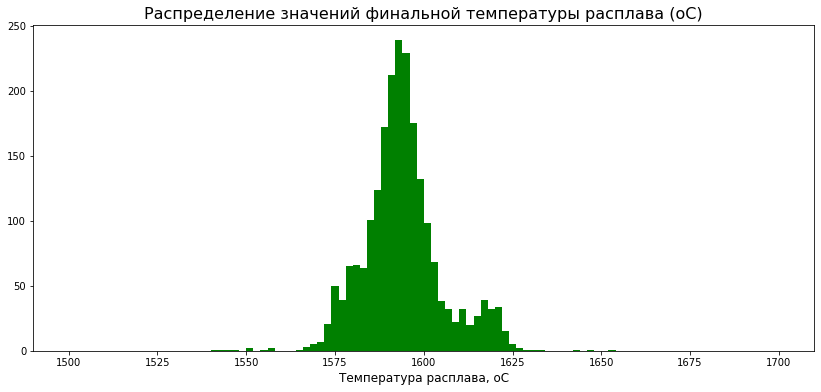

In [84]:
plt.figure(figsize = (14,6))
plt.hist(target_final['final_temp'], range = (1500, 1700), bins = 100, color = 'green')
plt.xlabel('Температура расплава, оС', fontsize = 12)
plt.title('Распределение значений финальной температуры расплава (оС)', fontsize = 16)
plt.show()

Распределение "нормально", однако слева и справа видны аномалии. Построим "усатый ящик" и подумаем - выбрасывать нам эти значения или нет.

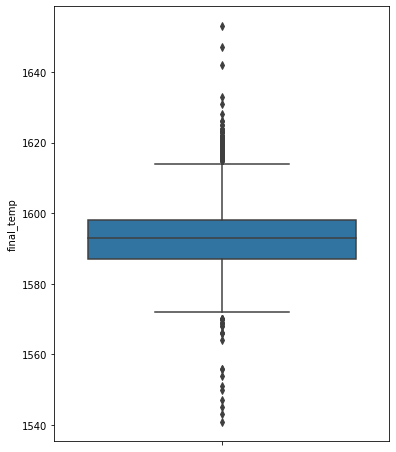

In [85]:
plt.figure(figsize = (6,8))
sns.boxplot(y = target_final['final_temp'])

Выбросов не особо много, думаю мы можем ограничиться 1 и 99 квантилями. Все остальное - под нож.

In [86]:
target_q_1 = np.quantile(target_final['final_temp'], 0.01)
target_q_99 = np.quantile(target_final['final_temp'], 0.99)

In [87]:
target_final = target_final[(target_final['final_temp'] > target_q_1) & (target_final['final_temp'] < target_q_99)]
target_final

,final_temp
fit_keys,
1,1613.0
2,1602.0
3,1599.0
5,1602.0
6,1596.0
...,...
2495,1591.0
2496,1591.0
2497,1589.0


> Это Дмитрий из будущего. Я вернулся в эту точку, что бы создать копию ещё не измененного датасета с признаками - для ПРЕДОБРАБОТКИ 2.0. Верь мне, я программист (нет).

In [88]:
final_features = final_features.loc[target_final.index]
final_features_raw = final_features.copy()
final_features

,mean_active_power,mean_power_coef,heat_cycles_number,heat_time,start_temp,bulk_mass,bulk_count,wire_mass,wire_count,length,gas_avg
fit_keys,,,,,,,,,,,
1,1.176059,0.850147,2,513,1571.0,43.0,1,0.000000,0,861,0.027095
2,0.871512,0.840235,3,674,1581.0,582.0,4,96.052315,1,1305,0.015482
3,0.365957,0.845469,4,375,1596.0,34.0,1,91.160157,1,1300,0.043595
5,0.944561,0.833342,2,486,1576.0,0.0,0,9.114560,1,762,0.006230
6,1.206989,0.833260,3,849,1543.0,676.0,4,108.224477,2,1385,0.011842
...,...,...,...,...,...,...,...,...,...,...,...
2495,0.778556,0.816892,3,516,1570.0,111.0,2,89.150879,1,1137,0.009856
2496,0.761888,0.834256,5,823,1554.0,796.0,5,114.179527,1,1618,0.010013
2497,0.815698,0.771318,2,413,1571.0,85.0,1,103.134723,2,717,0.011022


Поехали по признакам.

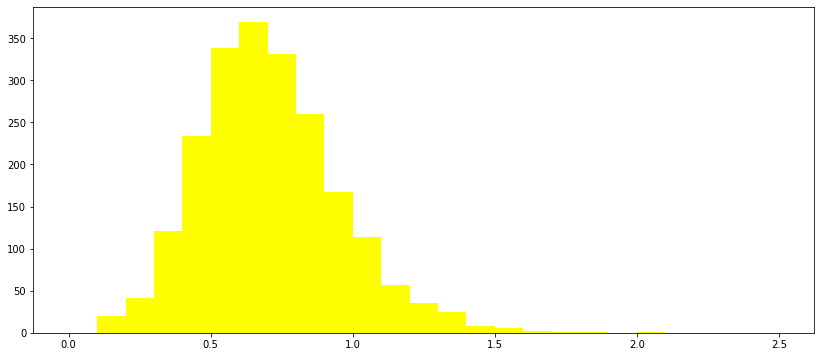

In [89]:
plt.figure(figsize = (14,6))
plt.hist(final_features.iloc[:,0], range = (0, 2.5), bins = 25, color = 'yellow')
plt.show()

Распределение нормально, всё круто, можно использовать дальше. \
Здесь мы вполне "на глаз" можем обрезать верхушку данных по уровню 1.5.

In [90]:
final_features = final_features[final_features.iloc[:,0] < 1.5]
final_features

,mean_active_power,mean_power_coef,heat_cycles_number,heat_time,start_temp,bulk_mass,bulk_count,wire_mass,wire_count,length,gas_avg
fit_keys,,,,,,,,,,,
1,1.176059,0.850147,2,513,1571.0,43.0,1,0.000000,0,861,0.027095
2,0.871512,0.840235,3,674,1581.0,582.0,4,96.052315,1,1305,0.015482
3,0.365957,0.845469,4,375,1596.0,34.0,1,91.160157,1,1300,0.043595
5,0.944561,0.833342,2,486,1576.0,0.0,0,9.114560,1,762,0.006230
6,1.206989,0.833260,3,849,1543.0,676.0,4,108.224477,2,1385,0.011842
...,...,...,...,...,...,...,...,...,...,...,...
2495,0.778556,0.816892,3,516,1570.0,111.0,2,89.150879,1,1137,0.009856
2496,0.761888,0.834256,5,823,1554.0,796.0,5,114.179527,1,1618,0.010013
2497,0.815698,0.771318,2,413,1571.0,85.0,1,103.134723,2,717,0.011022


Далее.

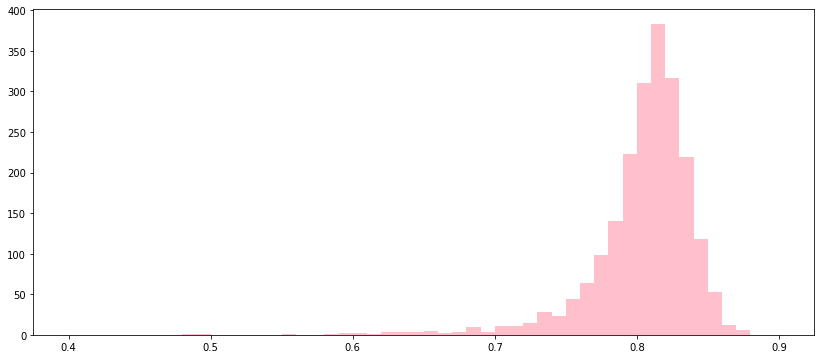

In [91]:
plt.figure(figsize = (14,6))
plt.hist(final_features.iloc[:,1], range = (0.4, 0.9), bins = 50, color = 'pink')
plt.show()

Распределение - "Норм". \
Справа резать нечего, но можно убрать кусочек слева. Посмотрим где можно расположить границу.

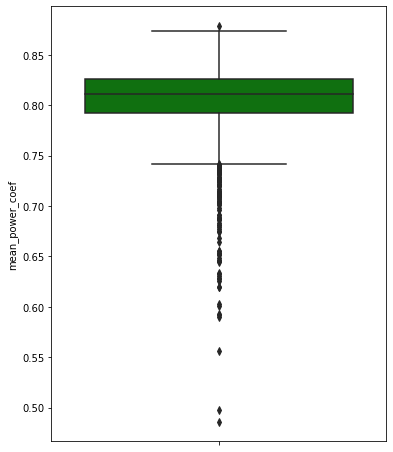

In [92]:
plt.figure(figsize = (6,8))
sns.boxplot(y = final_features.iloc[:,1], color = 'green')
plt.show()

Полагаю, что уровень 0.73 - слишком "большой" для обрезки. Ограничимся значением в 0.7, обрежем и перейдем к следующему признаку.

In [93]:
final_features = final_features[final_features.iloc[:,1] > 0.7]
final_features

,mean_active_power,mean_power_coef,heat_cycles_number,heat_time,start_temp,bulk_mass,bulk_count,wire_mass,wire_count,length,gas_avg
fit_keys,,,,,,,,,,,
1,1.176059,0.850147,2,513,1571.0,43.0,1,0.000000,0,861,0.027095
2,0.871512,0.840235,3,674,1581.0,582.0,4,96.052315,1,1305,0.015482
3,0.365957,0.845469,4,375,1596.0,34.0,1,91.160157,1,1300,0.043595
5,0.944561,0.833342,2,486,1576.0,0.0,0,9.114560,1,762,0.006230
6,1.206989,0.833260,3,849,1543.0,676.0,4,108.224477,2,1385,0.011842
...,...,...,...,...,...,...,...,...,...,...,...
2495,0.778556,0.816892,3,516,1570.0,111.0,2,89.150879,1,1137,0.009856
2496,0.761888,0.834256,5,823,1554.0,796.0,5,114.179527,1,1618,0.010013
2497,0.815698,0.771318,2,413,1571.0,85.0,1,103.134723,2,717,0.011022


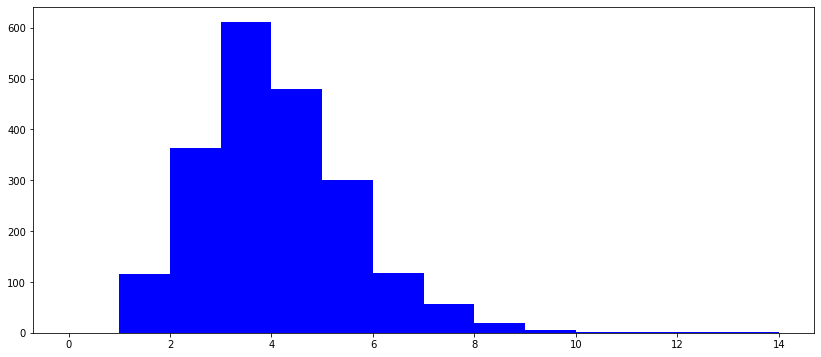

In [94]:
plt.figure(figsize = (14,6))
plt.hist(final_features.iloc[:,2], range = (0, 14), bins = 14, color = 'blue')
plt.show()

Удаляем всё, что больше 10. Остальное - сохраняем.

In [95]:
final_features = final_features[final_features.iloc[:,2] <= 10]
final_features

,mean_active_power,mean_power_coef,heat_cycles_number,heat_time,start_temp,bulk_mass,bulk_count,wire_mass,wire_count,length,gas_avg
fit_keys,,,,,,,,,,,
1,1.176059,0.850147,2,513,1571.0,43.0,1,0.000000,0,861,0.027095
2,0.871512,0.840235,3,674,1581.0,582.0,4,96.052315,1,1305,0.015482
3,0.365957,0.845469,4,375,1596.0,34.0,1,91.160157,1,1300,0.043595
5,0.944561,0.833342,2,486,1576.0,0.0,0,9.114560,1,762,0.006230
6,1.206989,0.833260,3,849,1543.0,676.0,4,108.224477,2,1385,0.011842
...,...,...,...,...,...,...,...,...,...,...,...
2495,0.778556,0.816892,3,516,1570.0,111.0,2,89.150879,1,1137,0.009856
2496,0.761888,0.834256,5,823,1554.0,796.0,5,114.179527,1,1618,0.010013
2497,0.815698,0.771318,2,413,1571.0,85.0,1,103.134723,2,717,0.011022


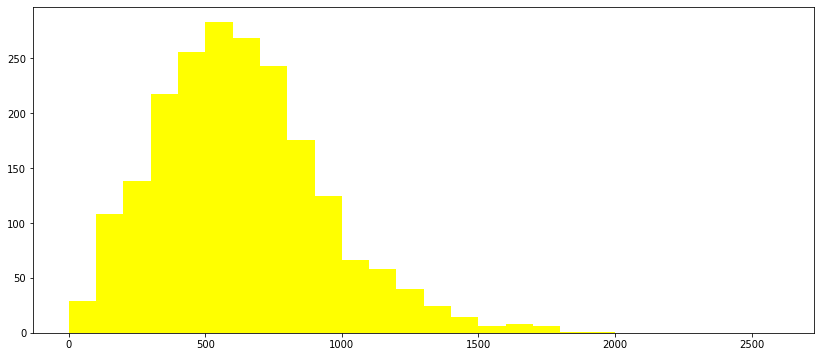

In [96]:
plt.figure(figsize = (14,6))
plt.hist(final_features.iloc[:,3], range = (0, 2600), bins = 26, color = 'yellow')
plt.show()

Все, что больше 1500 - в огонь. 

In [97]:
final_features = final_features[final_features.iloc[:,3] <= 1500]
final_features

,mean_active_power,mean_power_coef,heat_cycles_number,heat_time,start_temp,bulk_mass,bulk_count,wire_mass,wire_count,length,gas_avg
fit_keys,,,,,,,,,,,
1,1.176059,0.850147,2,513,1571.0,43.0,1,0.000000,0,861,0.027095
2,0.871512,0.840235,3,674,1581.0,582.0,4,96.052315,1,1305,0.015482
3,0.365957,0.845469,4,375,1596.0,34.0,1,91.160157,1,1300,0.043595
5,0.944561,0.833342,2,486,1576.0,0.0,0,9.114560,1,762,0.006230
6,1.206989,0.833260,3,849,1543.0,676.0,4,108.224477,2,1385,0.011842
...,...,...,...,...,...,...,...,...,...,...,...
2495,0.778556,0.816892,3,516,1570.0,111.0,2,89.150879,1,1137,0.009856
2496,0.761888,0.834256,5,823,1554.0,796.0,5,114.179527,1,1618,0.010013
2497,0.815698,0.771318,2,413,1571.0,85.0,1,103.134723,2,717,0.011022


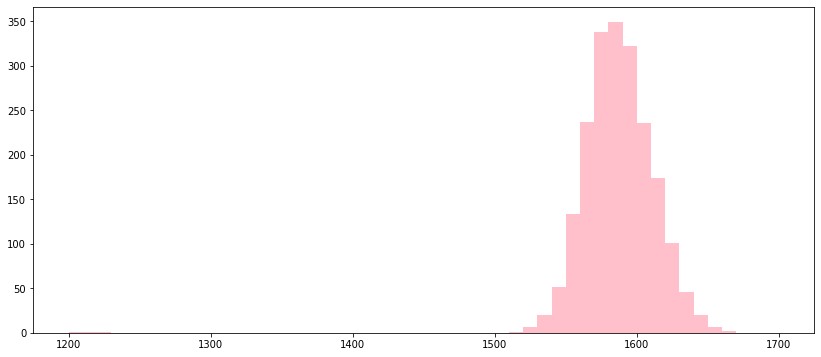

In [98]:
plt.figure(figsize = (14,6))
plt.hist(final_features.iloc[:,4], range = (1200, 1700), bins = 50, color = 'pink')
plt.show()

Все что меньше 1500 - так же под нож.

In [99]:
final_features = final_features[final_features.iloc[:,4] >= 1500]
final_features

,mean_active_power,mean_power_coef,heat_cycles_number,heat_time,start_temp,bulk_mass,bulk_count,wire_mass,wire_count,length,gas_avg
fit_keys,,,,,,,,,,,
1,1.176059,0.850147,2,513,1571.0,43.0,1,0.000000,0,861,0.027095
2,0.871512,0.840235,3,674,1581.0,582.0,4,96.052315,1,1305,0.015482
3,0.365957,0.845469,4,375,1596.0,34.0,1,91.160157,1,1300,0.043595
5,0.944561,0.833342,2,486,1576.0,0.0,0,9.114560,1,762,0.006230
6,1.206989,0.833260,3,849,1543.0,676.0,4,108.224477,2,1385,0.011842
...,...,...,...,...,...,...,...,...,...,...,...
2495,0.778556,0.816892,3,516,1570.0,111.0,2,89.150879,1,1137,0.009856
2496,0.761888,0.834256,5,823,1554.0,796.0,5,114.179527,1,1618,0.010013
2497,0.815698,0.771318,2,413,1571.0,85.0,1,103.134723,2,717,0.011022


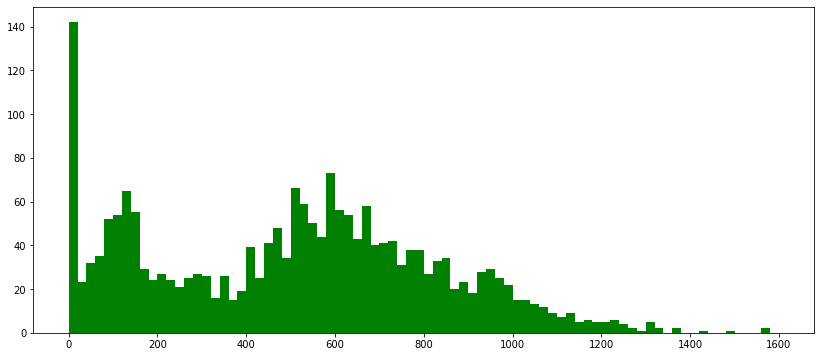

In [100]:
plt.figure(figsize = (14,6))
plt.hist(final_features.iloc[:,5], range = (0, 1600), bins = 80, color = 'green')
plt.show()

Форма распределения - крайне "сомнительна". Вероятно, стоит с этим что-то сделать. Попробуем найти "среднее" значение на каждую "итерацию внесения" и посмотрим на распределение ещё раз. 

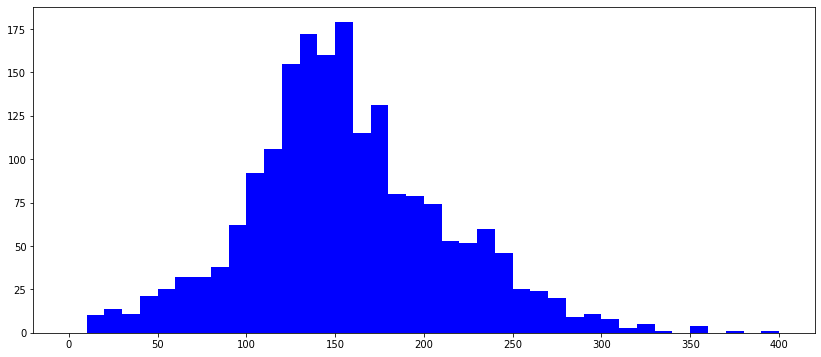

In [101]:
plt.figure(figsize = (14,6))
plt.hist(final_features.iloc[:,5] / final_features.iloc[:,6], range = (0,400), bins = 40, color = 'blue')
plt.show()

Миленько. Так и оставим. Данное распределение куда "нормальней" и оттого для наших задач - наиболее подходящее. Супер! Переведём наш столбец в "нужный" формат.

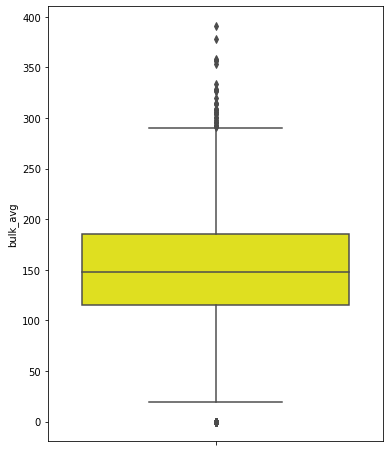

,mean_active_power,mean_power_coef,heat_cycles_number,heat_time,start_temp,bulk_mass,bulk_count,wire_mass,wire_count,length,gas_avg,bulk_avg
fit_keys,,,,,,,,,,,,
1,1.176059,0.850147,2,513,1571.0,43.0,1,0.000000,0,861,0.027095,43.0
2,0.871512,0.840235,3,674,1581.0,582.0,4,96.052315,1,1305,0.015482,145.5
3,0.365957,0.845469,4,375,1596.0,34.0,1,91.160157,1,1300,0.043595,34.0
5,0.944561,0.833342,2,486,1576.0,0.0,0,9.114560,1,762,0.006230,0.0
6,1.206989,0.833260,3,849,1543.0,676.0,4,108.224477,2,1385,0.011842,169.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0.778556,0.816892,3,516,1570.0,111.0,2,89.150879,1,1137,0.009856,55.5
2496,0.761888,0.834256,5,823,1554.0,796.0,5,114.179527,1,1618,0.010013,159.2
2497,0.815698,0.771318,2,413,1571.0,85.0,1,103.134723,2,717,0.011022,85.0


In [102]:
plt.figure(figsize = (6,8))

final_features['bulk_avg'] = final_features['bulk_mass'] / final_features['bulk_count']
final_features = final_features.fillna(0)

sns.boxplot(y = final_features['bulk_avg'], color = 'yellow')
plt.show()
display(final_features)

В принципе, обрезать РОВНО по верхнему "усу" не имеет смысла - нас вполне устроит "убирание" всего, что больше 300. Уберем этом и продолжим наше путешествие.

In [103]:
final_features = final_features[final_features['bulk_avg'] <= 300]
final_features

,mean_active_power,mean_power_coef,heat_cycles_number,heat_time,start_temp,bulk_mass,bulk_count,wire_mass,wire_count,length,gas_avg,bulk_avg
fit_keys,,,,,,,,,,,,
1,1.176059,0.850147,2,513,1571.0,43.0,1,0.000000,0,861,0.027095,43.0
2,0.871512,0.840235,3,674,1581.0,582.0,4,96.052315,1,1305,0.015482,145.5
3,0.365957,0.845469,4,375,1596.0,34.0,1,91.160157,1,1300,0.043595,34.0
5,0.944561,0.833342,2,486,1576.0,0.0,0,9.114560,1,762,0.006230,0.0
6,1.206989,0.833260,3,849,1543.0,676.0,4,108.224477,2,1385,0.011842,169.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0.778556,0.816892,3,516,1570.0,111.0,2,89.150879,1,1137,0.009856,55.5
2496,0.761888,0.834256,5,823,1554.0,796.0,5,114.179527,1,1618,0.010013,159.2
2497,0.815698,0.771318,2,413,1571.0,85.0,1,103.134723,2,717,0.011022,85.0


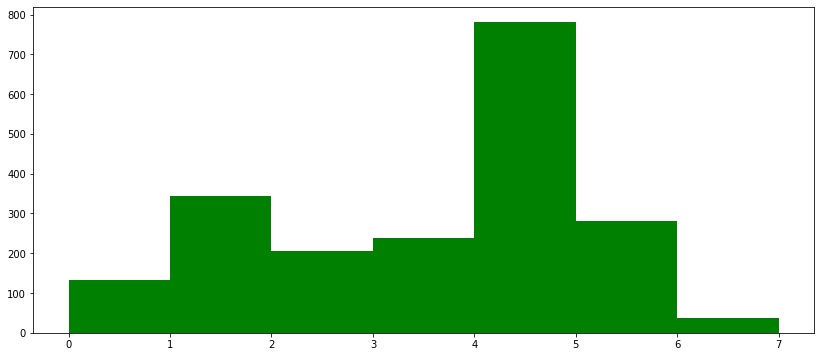

In [104]:
plt.figure(figsize = (14,6))
plt.hist(final_features.iloc[:,6], range = (0,7), bins = 7, color = 'green')
plt.show()

Здесь особо ничего сделать не получится - распределение как распределение. Двигаемся дальше.

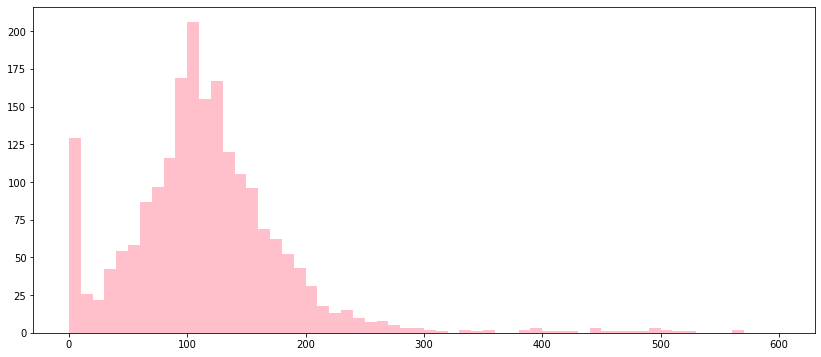

In [105]:
plt.figure(figsize = (14,6))
plt.hist(final_features.iloc[:,7], range = (0,600), bins = 60, color = 'pink')
plt.show()

А вот "проволочное распределение" куда более "нормально", нежели "сыпучее". Посмотрим, во что можно его превратить, если провести аналогичное "усреднение".

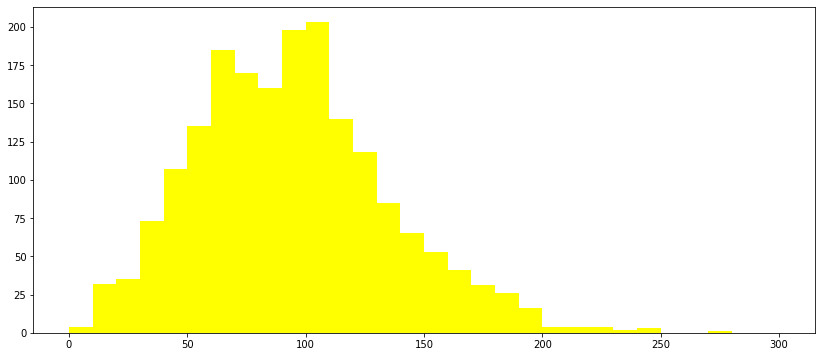

In [106]:
plt.figure(figsize = (14,6))
plt.hist(final_features.iloc[:,7] / final_features.iloc[:,8], bins = 30, range = (0,300), color = 'yellow')
plt.show()

Действительно, стало "нормальней" - "отвалился" правый "хвост" - теперь нужно отбросить совсем чуть-чуть. 

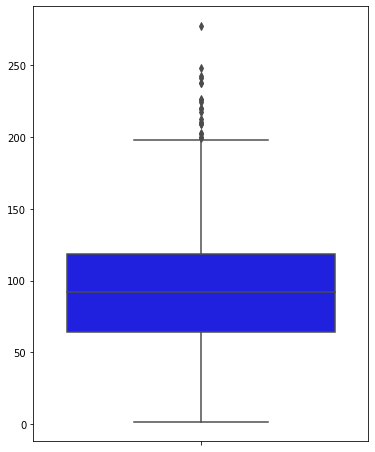

In [107]:
plt.figure(figsize = (6,8))
sns.boxplot(y = final_features.iloc[:,7] / final_features.iloc[:,8], color = 'blue')
plt.show()

А вот тут я готов согласиться с "усами" - всё что больше 200 можно удалить. Но сперва создадим соответствующий столбец в таблице.

In [108]:
final_features['wire_avg'] = final_features['wire_mass'] / final_features['wire_count']
final_features = final_features.fillna(0)
final_features = final_features[final_features['wire_avg'] <= 200]
final_features

,mean_active_power,mean_power_coef,heat_cycles_number,heat_time,start_temp,bulk_mass,bulk_count,wire_mass,wire_count,length,gas_avg,bulk_avg,wire_avg
fit_keys,,,,,,,,,,,,,
1,1.176059,0.850147,2,513,1571.0,43.0,1,0.000000,0,861,0.027095,43.0,0.000000
2,0.871512,0.840235,3,674,1581.0,582.0,4,96.052315,1,1305,0.015482,145.5,96.052315
3,0.365957,0.845469,4,375,1596.0,34.0,1,91.160157,1,1300,0.043595,34.0,91.160157
5,0.944561,0.833342,2,486,1576.0,0.0,0,9.114560,1,762,0.006230,0.0,9.114560
6,1.206989,0.833260,3,849,1543.0,676.0,4,108.224477,2,1385,0.011842,169.0,54.112238
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0.778556,0.816892,3,516,1570.0,111.0,2,89.150879,1,1137,0.009856,55.5,89.150879
2496,0.761888,0.834256,5,823,1554.0,796.0,5,114.179527,1,1618,0.010013,159.2,114.179527
2497,0.815698,0.771318,2,413,1571.0,85.0,1,103.134723,2,717,0.011022,85.0,51.567362


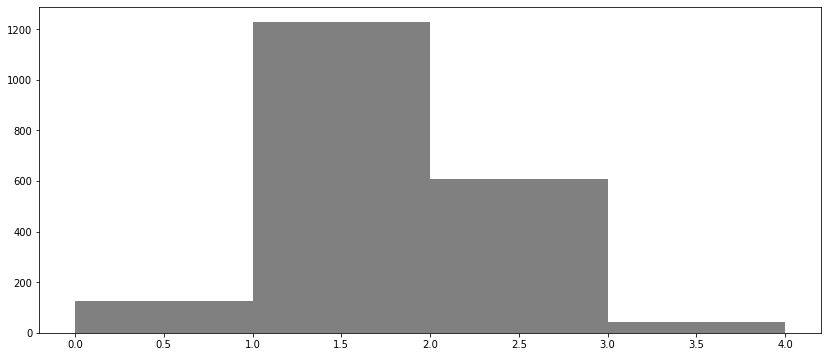

In [109]:
plt.figure(figsize = (14,6))
plt.hist(final_features.iloc[:,8], color = 'grey', bins = 4, range = (0,4))
plt.show()

Продолжаем. Тут нам делать нечего.

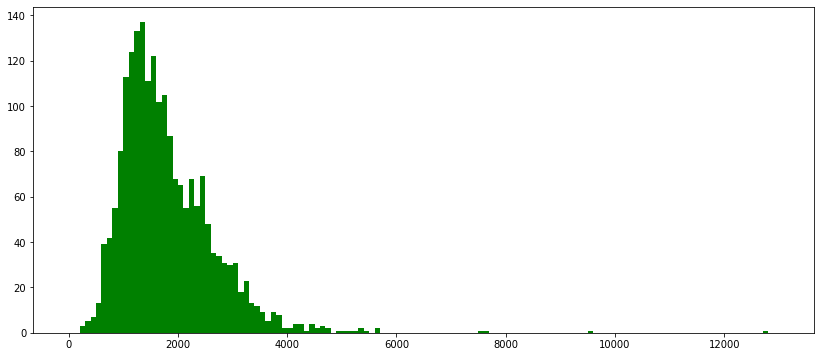

In [110]:
plt.figure(figsize = (14,6))
plt.hist(final_features.iloc[:,9], color = 'green', bins = 130, range = (0,13000))
plt.show()

Особо длительные истории стоит "устранить". Смотрим "усы", обрезаем и двигаемся дальше.

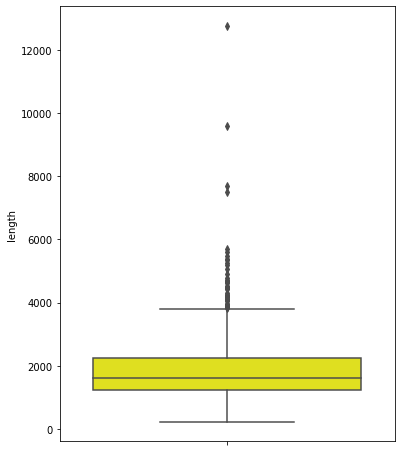

In [111]:
plt.figure(figsize = (6,8))
sns.boxplot(y = final_features.iloc[:,9], color = 'yellow')
plt.show()

4000 - подходящий нам лимит. Режем.

In [112]:
final_features = final_features[final_features.iloc[:,9] <= 4000]
final_features

,mean_active_power,mean_power_coef,heat_cycles_number,heat_time,start_temp,bulk_mass,bulk_count,wire_mass,wire_count,length,gas_avg,bulk_avg,wire_avg
fit_keys,,,,,,,,,,,,,
1,1.176059,0.850147,2,513,1571.0,43.0,1,0.000000,0,861,0.027095,43.0,0.000000
2,0.871512,0.840235,3,674,1581.0,582.0,4,96.052315,1,1305,0.015482,145.5,96.052315
3,0.365957,0.845469,4,375,1596.0,34.0,1,91.160157,1,1300,0.043595,34.0,91.160157
5,0.944561,0.833342,2,486,1576.0,0.0,0,9.114560,1,762,0.006230,0.0,9.114560
6,1.206989,0.833260,3,849,1543.0,676.0,4,108.224477,2,1385,0.011842,169.0,54.112238
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0.778556,0.816892,3,516,1570.0,111.0,2,89.150879,1,1137,0.009856,55.5,89.150879
2496,0.761888,0.834256,5,823,1554.0,796.0,5,114.179527,1,1618,0.010013,159.2,114.179527
2497,0.815698,0.771318,2,413,1571.0,85.0,1,103.134723,2,717,0.011022,85.0,51.567362


Последний признак - "газовый".

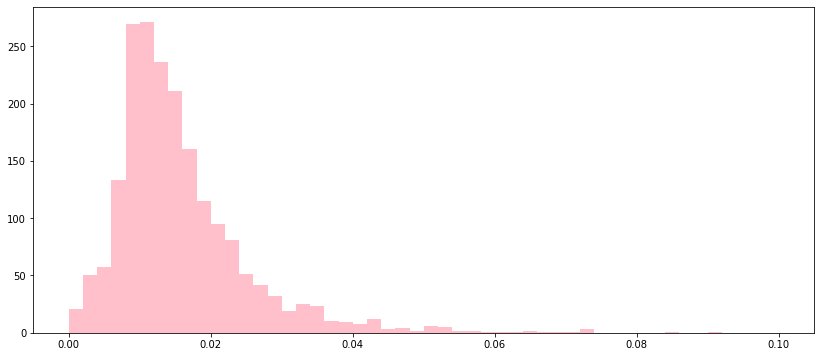

In [113]:
plt.figure(figsize = (14,6))
plt.hist(final_features.iloc[:,10], color = 'pink', bins = 50, range = (0,0.1))
plt.show()

Нормальность "обнаружена", а вот правый хвост стоит обрезать. Вот только где? Посмотрим по "усам".

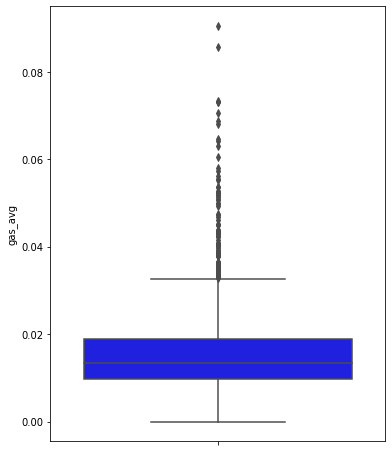

In [114]:
plt.figure(figsize = (6,8))
sns.boxplot(y = final_features.iloc[:,10], color = 'blue')
plt.show()

0.04 - наш кандидат. "Усам" - не доверяем.

In [115]:
final_features = final_features[final_features.iloc[:,10] < 0.04]
final_features

,mean_active_power,mean_power_coef,heat_cycles_number,heat_time,start_temp,bulk_mass,bulk_count,wire_mass,wire_count,length,gas_avg,bulk_avg,wire_avg
fit_keys,,,,,,,,,,,,,
1,1.176059,0.850147,2,513,1571.0,43.0,1,0.000000,0,861,0.027095,43.00,0.000000
2,0.871512,0.840235,3,674,1581.0,582.0,4,96.052315,1,1305,0.015482,145.50,96.052315
5,0.944561,0.833342,2,486,1576.0,0.0,0,9.114560,1,762,0.006230,0.00,9.114560
6,1.206989,0.833260,3,849,1543.0,676.0,4,108.224477,2,1385,0.011842,169.00,54.112238
7,0.720097,0.851769,3,555,1586.0,627.0,4,98.061600,1,1374,0.014616,156.75,98.061600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0.778556,0.816892,3,516,1570.0,111.0,2,89.150879,1,1137,0.009856,55.50,89.150879
2496,0.761888,0.834256,5,823,1554.0,796.0,5,114.179527,1,1618,0.010013,159.20,114.179527
2497,0.815698,0.771318,2,413,1571.0,85.0,1,103.134723,2,717,0.011022,85.00,51.567362


Предобработка унесла с собой ещё почти 10% от данных. Да, неприятно, однако, теперь, с "нормальными" распределениями можно делать настоящую крутую модель! Уберём лишние столбцы, скорректируем столбец целевого признака и отправимся подбирать и обучать модель.

In [116]:
features_ready = final_features.copy().drop(['bulk_mass', 'wire_mass'], axis = 1)
features_ready

,mean_active_power,mean_power_coef,heat_cycles_number,heat_time,start_temp,bulk_count,wire_count,length,gas_avg,bulk_avg,wire_avg
fit_keys,,,,,,,,,,,
1,1.176059,0.850147,2,513,1571.0,1,0,861,0.027095,43.00,0.000000
2,0.871512,0.840235,3,674,1581.0,4,1,1305,0.015482,145.50,96.052315
5,0.944561,0.833342,2,486,1576.0,0,1,762,0.006230,0.00,9.114560
6,1.206989,0.833260,3,849,1543.0,4,2,1385,0.011842,169.00,54.112238
7,0.720097,0.851769,3,555,1586.0,4,1,1374,0.014616,156.75,98.061600
...,...,...,...,...,...,...,...,...,...,...,...
2495,0.778556,0.816892,3,516,1570.0,2,1,1137,0.009856,55.50,89.150879
2496,0.761888,0.834256,5,823,1554.0,5,1,1618,0.010013,159.20,114.179527
2497,0.815698,0.771318,2,413,1571.0,1,2,717,0.011022,85.00,51.567362


In [117]:
target_ready = target_final.loc[features_ready.index]
target_ready

,final_temp
fit_keys,
1,1613.0
2,1602.0
5,1602.0
6,1596.0
7,1599.0
...,...
2495,1591.0
2496,1591.0
2497,1589.0


# 3. Подбор, обучение и тестирование модели

Наконец, наконец, наконец - мы в разделе с подбором и обучением модели!

С чего начать?

Подумаем!

1) Перед нами - задача регрессии. Температура - количественный признак, а значит ни о какой классификации речи идти не может. 
2) Данных не особо много, стало быть нам нужна некая КРУТАЯ модель, которая "сможет и так". 

Начнем мы, по обыкновению, с линейной регрессии, посмотрим что можно получить "особо ничего не выдумывая" и, затем, подумаем на предмет градиентного бустинга на глупых деревьях. Или как-то так. \
Вообще, эта часть проекта дается мне пока "сложнее всего". Но это нормально. Как говорится, делай и будет.

Но в первую очередь - нарежем данные на обучающую, валидационную и тестовую выборки. \
Соотношение - 60 на 20 на 20.

In [118]:
(features_train, features_vt,
 target_train, target_vt) = train_test_split(features_ready, target_ready, test_size = 0.4, random_state = 11111)

(features_valid, features_test,
 target_valid, target_test) = train_test_split(features_vt, target_vt, test_size = 0.5, random_state = 11111)

display(features_train.shape)
display(features_valid.shape)
display(features_test.shape)

(1146, 11)

(382, 11)

(382, 11)

In [119]:
model_linreg = LinearRegression()
model_linreg.fit(features_train, target_train)

predicted = model_linreg.predict(features_valid)

mean_absolute_error(target_valid, predicted)

5.338524394970989

Очень интересно. Простейшая линейная регрессия позволила получить значение MAE равное 5.34. А по заданию - не более 6 для максимального балла. Хмммммм. А тимЛид говорил, что "на практике" было получено 5.7. Хмммммм.

Что бы это могло значить? Вероятно, вопрос к "использованным" данным, предобработке и т.д.

Или что-то ещё?

In [120]:
predicted_test = model_linreg.predict(features_test)

mean_absolute_error(target_test, predicted_test)

5.094204046022478

А на тестовой выборке - всё ещё интереснее. Я в замешательстве.

## Предобработка данных 2.0

Обратная связь - она такая - новые мысли, новые идеи, новые вопросы. Осталось только их реализовать и сделать это в срок!


Бизнес - действительно бизнес. Вполне возможно, что выбросы - не выбросы. Потому что насколько бы "случайным" процесс не был, на деле возможно всё что угодно. И что партия будет длиться несколько дней, и что ничего не будет добавлено, и что будет добавлено много БОЛЬШЕ, чем "хочется статистически" и т.д. и т.п.

Тем не менее, кто если не мы поможет этот вопрос решить?

Конечно же - никто. Выполним повторную предобработку данных, МИНИМИЗИРОВАВ "устранение неугодных" великой и ужасной СТАТИСТИКЕ.

> Единственные "обрезалки", которые я оставлю в данной предобработке без изменений - это обрезалки целевого признака. С этим не шутят!

Как хорошо, что в этом случае не придется заниматься "ручным" отбором границ для чистки. Что в этом хорошего? 

1) "Ручное" в программировании - это "дурной тон" (я читал, а ещё мне пацаны за гаражами рассказывали). Если можно автоматизировать - автоматизируй; \
2) Можно ускориться - найти для всех распределений значения 1 и 3 квартилей -(+) 3 * (интерквартильных размаха) - и по этим границам "обрезать" все имеющиеся столбцы. И всё будет ок. Быстро, просто и радостно. 

Пристегните ремни, поехали!

> Нам нужна функция, которая посчитает ВЕРХНЮЮ и НИЖНЮЮ границу нашего распределения - для каждого признака и "обрежет" данные по ним (удаляя всё, что ВНЕ этих границ).

In [121]:
final_features_raw

,mean_active_power,mean_power_coef,heat_cycles_number,heat_time,start_temp,bulk_mass,bulk_count,wire_mass,wire_count,length,gas_avg
fit_keys,,,,,,,,,,,
1,1.176059,0.850147,2,513,1571.0,43.0,1,0.000000,0,861,0.027095
2,0.871512,0.840235,3,674,1581.0,582.0,4,96.052315,1,1305,0.015482
3,0.365957,0.845469,4,375,1596.0,34.0,1,91.160157,1,1300,0.043595
5,0.944561,0.833342,2,486,1576.0,0.0,0,9.114560,1,762,0.006230
6,1.206989,0.833260,3,849,1543.0,676.0,4,108.224477,2,1385,0.011842
...,...,...,...,...,...,...,...,...,...,...,...
2495,0.778556,0.816892,3,516,1570.0,111.0,2,89.150879,1,1137,0.009856
2496,0.761888,0.834256,5,823,1554.0,796.0,5,114.179527,1,1618,0.010013
2497,0.815698,0.771318,2,413,1571.0,85.0,1,103.134723,2,717,0.011022


Новый этап предобработки требует дополнительных уточненй. 

1) Мы не предобрабатываем столбцы с КОЛИЧЕСТВОМ нагревов и введений добавок. Вообще. Пусть все данные в этих таблицах останутся живыми. Почему? Поскольку основной смысл проекта - снижение энергозатрат, нам необходимо определять температуру как раз для ОСОБЕННЫХ датасетов (Николай, спасибо!) - у которых больше обычного циклов нагрева (куда направляются основные энергозатраты), количеств введения добавок - ведь после каждого введения нужно снова нагревать и перемешивать и т.д. \
Следовательно, эти столбцы мы оставляем не тронутыми.

2) Сразу усредним значения в столбца bulk_mass и wire_mass.

In [122]:
column_list = ['mean_active_power', 'mean_power_coef',
               'heat_time', 'start_temp',
               'bulk_mass', 'wire_mass',
               'length', 'gas_avg']

final_features_dirty = final_features_raw.copy()

final_features_dirty['bulk_mass'] = final_features_raw['bulk_mass'] / final_features_raw['bulk_count']
final_features_dirty['wire_mass'] = final_features_raw['wire_mass'] / final_features_raw['wire_count'] 

final_features_dirty = final_features_dirty.fillna(0)

final_features_dirty.head()

,mean_active_power,mean_power_coef,heat_cycles_number,heat_time,start_temp,bulk_mass,bulk_count,wire_mass,wire_count,length,gas_avg
fit_keys,,,,,,,,,,,
1,1.176059,0.850147,2,513,1571.0,43.0,1,0.000000,0,861,0.027095
2,0.871512,0.840235,3,674,1581.0,145.5,4,96.052315,1,1305,0.015482
3,0.365957,0.845469,4,375,1596.0,34.0,1,91.160157,1,1300,0.043595
5,0.944561,0.833342,2,486,1576.0,0.0,0,9.114560,1,762,0.006230
6,1.206989,0.833260,3,849,1543.0,169.0,4,54.112238,2,1385,0.011842


In [123]:
%%time

def data_q3_irq_cleaner(data, column_list):
    data_new = data.copy()
    for column in column_list:
        q_3 = np.quantile(data[column].dropna(), 0.75)
        q_1 = np.quantile(data[column].dropna(), 0.25)
        irq = q_3 - q_1
        
        top_limit = q_3 + 3 * irq
        
        data_new = data_new[data_new[column] <= top_limit]
    
    return data_new

ready_features_dirty = data_q3_irq_cleaner(final_features_dirty, column_list)
ready_features_dirty

CPU times: user 19.3 ms, sys: 7.91 ms, total: 27.2 ms
Wall time: 48.8 ms


,mean_active_power,mean_power_coef,heat_cycles_number,heat_time,start_temp,bulk_mass,bulk_count,wire_mass,wire_count,length,gas_avg
fit_keys,,,,,,,,,,,
1,1.176059,0.850147,2,513,1571.0,43.0,1,0.000000,0,861,0.027095
2,0.871512,0.840235,3,674,1581.0,145.5,4,96.052315,1,1305,0.015482
3,0.365957,0.845469,4,375,1596.0,34.0,1,91.160157,1,1300,0.043595
5,0.944561,0.833342,2,486,1576.0,0.0,0,9.114560,1,762,0.006230
6,1.206989,0.833260,3,849,1543.0,169.0,4,54.112238,2,1385,0.011842
...,...,...,...,...,...,...,...,...,...,...,...
2495,0.778556,0.816892,3,516,1570.0,55.5,2,89.150879,1,1137,0.009856
2496,0.761888,0.834256,5,823,1554.0,159.2,5,114.179527,1,1618,0.010013
2497,0.815698,0.771318,2,413,1571.0,85.0,1,51.567362,2,717,0.011022


Больше данных - умнее модель. Хоть и не всегда. "Финально" обрезаем целевой признак и переходим к "обучению 2.0".

In [124]:
ready_target_dirty = target_final.loc[ready_features_dirty.index]
ready_target_dirty

,final_temp
fit_keys,
1,1613.0
2,1602.0
3,1599.0
5,1602.0
6,1596.0
...,...
2495,1591.0
2496,1591.0
2497,1589.0


## Обучение 2.0

По хорошей традиции - начинаем с нарезки данных и модели линейной регрессии.

In [125]:
(features_train_dirty, features_vt_dirty,
 target_train_dirty, target_vt_dirty) = train_test_split(ready_features_dirty, ready_target_dirty,
                                                         test_size = 0.4, random_state = 11111)

(features_valid_dirty, features_test_dirty,
 target_valid_dirty, target_test_dirty) = train_test_split(features_vt_dirty, target_vt_dirty,
                                                           test_size = 0.5, random_state = 11111)

display(features_train_dirty.shape)
display(features_valid_dirty.shape)
display(features_test_dirty.shape)

(1242, 11)

(414, 11)

(415, 11)

Данных чуть-чуть больше, посмотрим, что случится с точностью модели.

In [126]:
model_linreg_dirty = LinearRegression()
model_linreg_dirty.fit(features_train_dirty, target_train_dirty)

predicted_dirty = model_linreg_dirty.predict(features_valid_dirty)

mean_absolute_error(target_valid_dirty, predicted_dirty)

6.00169169595766

Вау! Действительно, сохранив большую часть "ТИПА-аномалий" (ибо это угодно БИЗНЕСУ!), мы получили модель, которая не проходит на "максимальный" балл. MAE больше 6!

Мне это не подходит! Двигаемся вглубь. 

Для начала попробуем нормализовать значения и воспользоваться кросс-валидацией. Для большей уверенности в конечном результате, конечно.

Не забудем объединить обучающий и валидационный датасет в один. 

In [127]:
features_cv = pd.concat([features_train_dirty, features_valid_dirty])
target_cv = pd.concat([target_train_dirty, target_valid_dirty])

print(features_cv.shape)
print(target_cv.shape)

(1656, 11)
(1656, 1)


In [128]:
model_linreg_cv_norm = LinearRegression(normalize = True)


-cross_val_score(model_linreg_cv_norm, features_cv, target_cv, 
                 scoring = 'neg_mean_absolute_error', cv = 4).mean()

6.25953693955652

И лучше не стало, и понятней не стало. Нормализация "не сработала" - что бы это не значило. 

Стало быть, настало время глупых деревьев и градиентного бустинга. 

Функцию позаимствую из предшествующих проектов. 

In [129]:
train_data = lgb.Dataset(features_train_dirty, label = target_train_dirty)
valid_data = lgb.Dataset(features_valid_dirty, label = target_valid_dirty)


In [130]:
num_rounds = 5000

def model_parameters(depth, learning_rate, num_leaves):
    
    evals_result = {}
    parameters_gbdt = {'objective': 'regression',
                       'metric': 'mae',
                       'boosting': 'gbdt',
                        'num_leaves': num_leaves,
                        'learning_rate' : learning_rate,
                        'max_depth' : depth
                      }
    
    start_time = time.time()    
    best_model = lgb.train(parameters_gbdt, train_data, num_rounds,
                               valid_sets = valid_data, early_stopping_rounds = 10,
                               evals_result = evals_result,
                               verbose_eval = 0
                              )

    worktime = time.time() - start_time

    return best_model, worktime

In [131]:
def hyper_finder(bottom_d, top_d, step_d, bottom_r, top_r, step_r):
    
    final_table = pd.DataFrame(data = [], columns = ['max_depth', 'learning_rate', 'leaves_num',
                                                     'iterations', 'time', 'mae'])
    i = 0
    
    for depth in range(bottom_d, top_d + 1, step_d):
        for rate in range(bottom_r, top_r + 1, step_r):  
                
            max_depth = depth
            learning_rate = float(rate / 100)
                
            model, worktime = model_parameters(max_depth, learning_rate, 31)
            
            final_table.loc[i, 'max_depth'] = max_depth
            final_table.loc[i, 'learning_rate'] = learning_rate
            final_table.loc[i, 'iterations'] = model.best_iteration
            final_table.loc[i, 'leaves_num'] = 31
            final_table.loc[i, 'time'] = worktime
            final_table.loc[i, 'mae'] = model.best_score['valid_0']['l1']
            i += 1
            
    return final_table.sort_values(by=['mae'])

In [132]:
%%time

hyper_finder(2, 52, 5, 5, 35 ,5).head()

CPU times: user 3min 27s, sys: 1.43 s, total: 3min 29s
Wall time: 3min 30s


,max_depth,learning_rate,leaves_num,iterations,time,mae
1,2,0.1,31,239,3.68842,5.28544
0,2,0.05,31,363,5.19215,5.30719
2,2,0.15,31,98,1.29952,5.33743
4,2,0.25,31,56,3.07889,5.33762
3,2,0.2,31,88,2.19702,5.3483


In [133]:
%%time
best_values = hyper_finder(2, 7, 1, 5, 15, 1).head()
best_values.iloc[0]

CPU times: user 5min 3s, sys: 1.93 s, total: 5min 5s
Wall time: 5min 7s


max_depth              3
learning_rate       0.12
leaves_num            31
iterations            93
time             4.58294
mae              5.25489
Name: 18, dtype: object

"Лучшая модель" - с MAE 5.25. Подходит ли нам такое значение? Да, вполне. Вот только что будет на тестовых данных?

Достанем лучшую модель и обучим её.

In [134]:
best_gbdt, worktime = model_parameters(best_values.iloc[0,0], best_values.iloc[0,1], best_values.iloc[0,2])
pred_gbdt = best_gbdt.predict(features_test_dirty)
mean_absolute_error(target_test_dirty, pred_gbdt)

5.941049698392526

Да, значение MAE чуть хуже чем на обучающе-валидационном сценарии, однако мы всё ещё в пределах MAE < 6. Тадам!

Ухудшение метрики может указывать на небольшое (совсем малюсенькое) переобучение модели. Но это не точно.

Теперь посмотрим на "вклад" признаков в результат - их влияние на целевой признак.

Возможно некоторые из них следует удалить и никогда более никому не показывать!

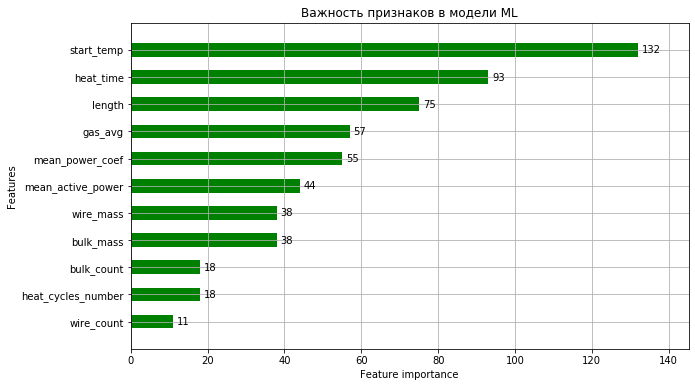

In [135]:
lgb.plot_importance(best_gbdt, height = 0.5, figsize = (10, 6), color = 'green',
                    title = 'Важность признаков в модели ML')

# Выводы

В процессе предобработки данных и обучения модели мы получили следующий результат:

1) Наибольшее влияние на итоговую температуру процесса оказывает именно СТАРТОВАЯ температура. Ибо 1600+ градусов есть 1600+ градусов. Остудить или нагреть огромную массу металла такой температуры - задача не тривиальная. Потому нам так важно фиксировать температуру в самом начале ВСЕГО процесса - чтобы иметь возможность моделировать (и прогнозировать) её изменение на всём технологическом процессе. 

2) Далее - длительность нагрева и длительность всей партии. Логично, т.к. от этих параметров напрямую зависит расход энергии (и, как следствие, температура стали). Принимается! Напротив, КОЛИЧЕСТВО циклов модель практически не "заботит" - что они есть, что их нет - влияния на конечный результат практически не ощущается.

3) Средний расход газа "плотно увязан" с длительностью нагрева, поэтому его присутствие в топе также весьма очевидно. 

4) Удивительно, что на первые места не вышли средний коэффициент мощности и средняя активная мощность, т.к. они (наряду с временем) в первых рядах выступают за энергопотребление (его рост или падение).

5) Чуть менее значимы - среднее количество добавок обоих видов за цикл. Логично. Их масса (100+ кг против 100 тонн) крайне мала, по сравнению с объемом ковша, в котором всё это дело происходит, однако, важность этих признаков неотъемлема. 

6) А вот от ЧИСЛА циклов нагрева, а также числа введения добавок (любых) можно было и отказаться, а массу добавок пустить в виде СУММАРНОГО ЗНАЧЕНИЯ. Но, как говорится, кто бы знал заранее.

# 4. Выводы 2.0 и отчёт по решению

Вопросов для "результации" четыре. 

- Какие пункты плана были выполнены, а какие — нет (поясните почему)?
- Какие трудности возникли и как вы их преодолели?
- Какие ключевые шаги в решении задачи выделили?
- Какая ваша итоговая модель и какое у неё качество?

### Выполненные пункты плана

Дать ответ можно только вспомнив - каким был план. \
Обобщая и сокращая мы получим следующий список (пункты 1 и 2 поменял местами):

1) **ВЫПОЛНЕНО** \
Определить, что мы вообще будем прогнозировать. В нашем случае это была конечная температура системы - её мы и выбрали в качестве целевого признака. Хотя, как я говорил ранее (+ как мне советовал наставник) - пожалуй, в реальном проекте (реальней самого реального) стоило подумать на предмет прогнозирования другого показателя - например, изменения температуры (дельты) (от начала до конца процесса);

2) **ВЫПОЛНЕНО** \
Выбрать и собрать признаки, которые будут (и могут) быть использованы для обучения модели. В нашем случае их получилось целых 11 штук:
- начальная температура системы;
- суммарная длительность нагрева;
- средняя активная мощность циклов нагрева;
- средний коэффициент мощности циклов нагрева;
- общая длительность ВСЕГО технологического процесса;
- средний расход газа (за каждую секунду нагрева);
- Количество внесенных "сыпучих" добавок;
- количество внесенных "проволочных" добавок;
- количество циклов нагрева;
- количество РАЗ внесения "сыпучей" добавки;
- количество РАЗ внесения "проволочной" добавки.

Они (вместе со значимостью) представлены на гистограмме ниже. 

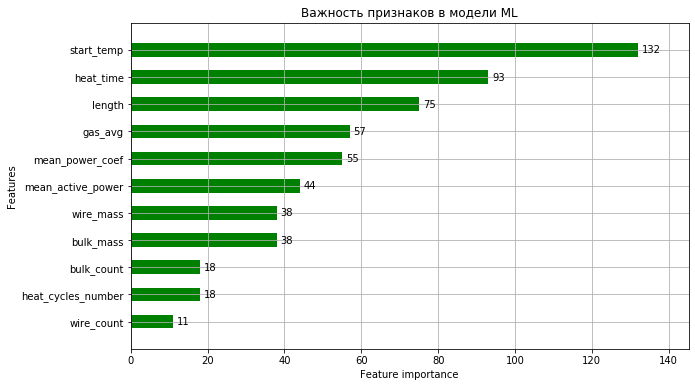

In [136]:
lgb.plot_importance(best_gbdt, height = 0.5, figsize = (10, 6), color = 'green',
                    title = 'Важность признаков в модели ML')

3+4) **ВЫПОЛНЕНО** \
Предобработка данных - убрать аномалии и т.д. \
Благодаря Николаю я теперь знаю больше - например, про теорию выбросов и межквартильный размах. \
В предобработке 1.0 я убрал "слишком много" значений - в том числе "живые" значения. И потому получил СВЕРХвысокую метрику MAE уже на линейной регрессии. \
Потому (Опять же, по совету Николая), я РАСШИРИЛ границы возможного РАЗБРОСА признаков и "исключил" только значения, выходящие за границы 1 и 3 квартилей -(+) 3 * интерквартильный размах. 
Метрики, полученные для данных, после предобработки 2.0 - оказались меньше целевого уровня MAE = 6.0, поэтому я воспользовался моделью градиентного бустинга и после небольшого перебора гиперапараметров получил модель со значением метрики MAE = 5.25 \
Время обучения модели не столь "влиятельно" - они все обучаются за примерно один временной интервал, поэтому минимальность MAE стало основным критерием выбора. 

5) **ДЕЛАЮ ПРЯМО СЕЙЧАС** 

### Ключевые шаги

1) Разобраться (самому или, при наличии, представителя от бизнеса) в технологическом (или любом другом) ОПИСЫВАЕМОМ процессе. Предложить возможные пути решения поставленной задачи и подготовить их (презентацию?);

2) Сформулировать вопросы ТимЛиду-наставнику-заказчику (тому, кому я подшефен - если подшефен :) ) и получить обратную связь;

3) На основе обратной связи - уточнить целевой признак, подобрать перечень признаков, разработать модель, получить результаты, подобрать гиперпараметры;

4) Показать ТимЛиду-наставнику-заказчику. Если что-то "НЕ ТО" - повторить пункт 3 до готовности (помешивать, пока не закипит :D ). 

### Итоговая модель

Итоговая модель - модель градиентного бустинга на решающих деревьях. 

> Максимальное глубина дерева = 3. \
Скорость обучения = 0.12. \
Максимальное количество листьев на дереве = 31 (что равно "стоковому" значению, поэтому не факт, что стоит об этом здесь писать). \
Обучается за 93 итерации. \
\
MAE = 5.25


Полагаю, что сама по себе модель, конечно, влияет на итоговую метрику (какой бы она ни была), однако, такая же (если не большая) роль - у того, КАК и в каком виде мы представляем обучающие данные. Одни и те же данные могут быть использованы ТАК, что в одном случае - не поможет и нейросеть, а во втором - будет достаточно линейной регрессии. 

Но как и всегда - истина где-то посередине - между предобработкой данных и подбором моделей. 

Спасибо за внимание!